### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
#import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

In [2]:
model_name = 'model-12-predict-keras-search-prelu'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False
fix_town_and_city = False
rare_village_threshold = 2
rare_town_threshold = 2
debugging = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

print('Target:', col_target)

Target: log_per_area_total_price


In [4]:
# Feature remove
# PARS #
N_feats_rm = 67
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

[[0 5709.20035 'divorce_rate' 3.333296666667593]
 [1 5709.200316666666 'I_250' 3.333263333333889]
 [2 5708.200346666667 'XI_100' 2.33329333333495]
 [3 5707.867050000001 'VI_index_500' 1.9999966666682667]
 [4 5707.86704 'IX_index_50' 1.9999866666676098]
 [5 5707.866983333333 'VI_500' 1.9999300000008589]
 [6 5707.533710000001 'XIV_10' 1.666656666668132]
 [7 5707.200386666666 'XI_index_500' 1.3333333333339397]
 [8 5707.200383333334 'VI_index_1000' 1.3333300000012969]
 [9 5707.200373333333 'V_100' 1.33332000000064]
 [10 5707.200363333334 'VII_10' 1.333310000001802]
 [11 5707.200336666666 'X_100' 1.3332833333333838]
 [12 5706.867056666667 'XII_index_50' 1.0000033333344618]
 [15 5706.867050000001 'X_index_500' 0.9999966666682667]
 [14 5706.867050000001 'X_10' 0.9999966666682667]
 [13 5706.867050000001 'II_10' 0.9999966666682667]
 [16 5706.867046666666 'II_index_500' 0.9999933333338049]
 [17 5706.867046666666 'V_index_1000' 0.9999933333338049]
 [18 5706.867043333335 'XIII_10' 0.99999000000207

### Columns

In [5]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

print('Total (before remove):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))

cols_num = [c for c in cols_num if c not in feats_rm]
cols_bin = [c for c in cols_bin if c not in feats_rm]
cols_cat = [c for c in cols_cat if c not in feats_rm]

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add), 
      'Total (after):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Total (before remove): 213
Num: 130 Bin: 7 Cat: 7
Add: 1 0 1 Total (after): 146


### Read data

In [6]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)
display(train.head(5))
display(test.head(5))

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv('dataset/id_cv'+str(i)+'.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696


,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,X5gsdTWGS3W7JJQB,1,13,18634,2,4,2,1857,2,NaN,...,7,21,1,129,1,3991,1,8409,1,105.4622312795739
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,18,44,1,67,1,1950,1,10725,1,100.81980868401074
2,dhdymr0lV8N5kZOT,8,12,19769,4,4,10,18294,2,NaN,...,0,3,1,35,1,3707,1,19459,1,259.8005430183116
3,VEwyGGMcD56w5BOc,10,7,20479,19,2,0,17837,2,NaN,...,16,60,1,144,1,6487,1,29400,1,22.941906168328487
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,4,18,1,76,1,1346,1,3280,1,181.21309507601745


### Preprocessing

In [7]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    # fix town and city
    if fix_town_and_city:
        df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
        df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    return df

In [8]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [9]:
train = pre_processing(train, cols_num, cols_cat, cols_bin)
test = pre_processing(test, cols_num, cols_cat, cols_bin)

/home/louis.yang.925/.local/lib/python3.5/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/louis.yang.925/.local/lib/python3.5/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', len(cols_feats))

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', len(cols_tar_encoded))

# Compute skew columns
cols_right_skew = [c for c in cols_num if train[c].skew() > 2.2]
print('\nRight skew columns:', len(cols_right_skew))

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: 146

Target mean encoded columns: 0

Right skew columns: 57


### Feature engineering
Include cat encoding, fillna, scaling

In [11]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [12]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4, rare_village_threshold=2, rare_town_threshold=2):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Rare village and town
        self.rare_town_threshold = rare_town_threshold
        self.rare_village_threshold = rare_village_threshold
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
    def fit_transform(self, df, df_test):
        df = df.copy()   
        
        # Rare village and town
        train_towns = df['town'].value_counts()
        rare_towns = (set(train_towns.index[train_towns <= self.rare_town_threshold])
                      - set(df_test['town']))
        df.loc[df['town'].isin(rare_towns), 'town'] = np.nan
        
        train_villages = df['village'].value_counts()        
        rare_villages = (set(train_villages.index[train_villages <= self.rare_village_threshold])
                         - set(df_test['village']))
        df.loc[df['village'].isin(rare_villages), 'village'] = np.nan
        
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

#### Debug

In [13]:
# for debug only
feat_eng_t = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,)
dfp2 = feat_eng_t.fit_transform(train, test)
df_test_2 = feat_eng_t.transform(test)

In [14]:
for c in cols_cat:
    print(c, dfp2[c].min(), df_test_2[c].min())

building_material 1 1
city 1 1
building_type 1 1
building_use 1 1
parking_way 1 1
town 0 0
village 0 0
encoded_latlon 1 1


In [15]:
train.info()
dfp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 253 entries, building_id to land_per_building_area
dtypes: float32(145), int32(8), int64(10), object(90)
memory usage: 80.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 254 entries, building_id to log_per_area_total_price_scaled
dtypes: float32(146), int16(2), int64(10), int8(6), object(90)
memory usage: 79.8+ MB


In [16]:
dfp2['building_area_ori'].check()

0         3.418175
1         4.041309
2         5.584279
3        13.563030
4         4.688108
59995     6.754059
59996     5.356788
59997     8.223644
59998     8.728287
59999     5.356788
Name: building_area_ori, dtype: float32

shape = (60000,)


In [17]:
#dfp2.loc[:, cols_right_skew].check()

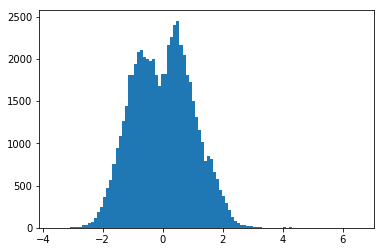

In [18]:
plt.hist(dfp2['log_per_area_total_price_scaled'], bins=100); plt.show()

In [19]:
if debugging:
    for c in cols_num:
        plt.figure(figsize=(12, 2))
        plt.hist(dfp2[c], bins=100)
        plt.xlabel('num: '+c); plt.show()
    for c in cols_bin:
        plt.figure(figsize=(12, 2))
        plt.hist(dfp2[c], bins=100)
        plt.xlabel('bin: '+c); plt.show()

In [20]:
if debugging:
    for c in cols_tar_encoded:
        plt.figure(figsize=(12, 2))
        plt.hist(dfp2[c], bins=100)
        plt.xlabel('tar: '+c); plt.show()

### Keras Model

In [21]:
import keras
import tensorflow as tf
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

from keras.models import Model
from keras.layers import (
    Input, Dense, Embedding, Flatten, Reshape, concatenate, Dropout, BatchNormalization, 
    Activation, Add, PReLU
)
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


keras: 2.2.4 tensorflow: 1.14.0


In [22]:
from keras_get_best import GetBest
#from keras_SGDRScheduler import SGDRScheduler

In [23]:
def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(1024,)*10, learning_rate=0.001, optimizer=Adam, loss='mse', 
                skip_connection=False, batch_norm=False, activation='relu', dropout=0.,
                **ignored):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    if skip_connection:
        assert all([x==n_neurons[0] for x in n_neurons]), 'Residual connection only work' \
            ' for square shape network'
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for i, n in enumerate(n_neurons):
        if skip_connection and i%2 == 1:
            skip_layer = x_layer
        x_layer = Dense(n)(x_layer)
        if activation == 'prelu':
            x_layer = PReLU()(x_layer)
        else:
            x_layer = Activation(activation)(x_layer)
        if dropout > 0. and i < len(n_neurons)-1:
            x_layer = Dropout(dropout)(x_layer)
        if batch_norm:
            x_layer = BatchNormalization()(x_layer)
        if skip_connection and i%2 == 0 and i > 0:
            x_layer = Add()([x_layer, skip_layer])
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    metrics = [m for m in ['mse', 'mae'] if m != loss]
    model.compile(optimizer=optimizer(lr=learning_rate), loss=loss, metrics=metrics)
    return model    

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

def plot_keras_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist:
                if c.endswith(m):
                    plt.plot(hist[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist_mean(hists, ylim=None, metrics_plot=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    keys_plot = [c for c in hists[0] for m in metrics_plot if c.endswith(m)]
    
    for c in keys_plot:
        plt.figure(figsize=(14, 4))
        array = np.zeros((len(hists[0][c]), len(hists)))
        for i, hist in enumerate(hists):
            array[:, i] = np.array(hist[c])
        sq_mean = array.mean(axis=1)
        sq_std = np.std(array, axis=1)
        #plt.errorbar(np.arange(1, len(sq_mean)+1), sq_mean, yerr=sq_std, label=c, alpha=0.9, fmt='-o')
        plt.plot(sq_mean, label=c+'_mean')
        plt.plot(sq_mean+sq_std, label=c+'_std+', alpha=0.5)
        plt.plot(sq_mean-sq_std, label=c+'_std-', alpha=0.5)
        if ylim != None: plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(c+'_mean')
        plt.legend(); plt.grid(); plt.show()

### Compute N parameters

In [24]:
def n_params(n_neurons, n_inputs=194):
    """ Compute N of parameters for the dense layers """
    n_params = n_neurons[0]*(n_inputs+1)
    for i in range(1, len(n_neurons)):
        n_params += (n_neurons[i-1]+1)*n_neurons[i]
    n_params += (n_neurons[-1]+1)
    return n_params

def solve_2nd_order_equation(a, b, c):
    """ Solve a*x^2 +b*x + c == 0 for x """
    return (-b+np.sqrt(b**2 - 4*a*c)) / (2*a) 

def solve_width_for_ratio(ratios, params, n_inputs=194):
    """ Solve the width given ratio for each layers and the total params.
        Assume the layers to be (width*ratios[0], width*ratios[1], width*ratios[2], ...)
    """
    b = ratios[0]*(n_inputs+1)
    a = 0
    for i in range(1, len(ratios)):
        a += ratios[i-1]*ratios[i]
        b += ratios[i]
    b += ratios[-1]
    c = 1 - params
    #print(a, b, c)
    return solve_2nd_order_equation(a, b, c)

def best_n_neurons(ratios, params, n_inputs=194):
    width = int(round(solve_width_for_ratio(ratios, params, n_inputs)))
    return tuple([width*x for x in ratios])

In [25]:
print(best_n_neurons(ratios=(1,1,1,1), params=25159840, n_inputs=219))

(2859, 2859, 2859, 2859)


In [26]:
np.power(3, 1/3)

1.4422495703074083

In [27]:
25159840*1.5

37739760.0

In [28]:
print(best_n_neurons(ratios=(8,4,2,1), params=37739760, n_inputs=240))

(7400, 3700, 1850, 925)


In [29]:
print(best_n_neurons(ratios=(6,4,2,1), params=37739760, n_inputs=219))

(6204, 4136, 2068, 1034)


In [30]:
1072*1.5

1608.0

### Params

In [31]:
params = {'epochs': 1600,  # 1608 , 1408
          'loss': 'mse',  # mse
          'activation': 'prelu',
          'batch_norm': True,
          'n_neurons': (7400, 3700, 1850, 925),
          'batch_size': 256,
          'embedding_ratio': 4,
          'learning_rate': 0.0009,
         }

if debugging:  # debugging only
    print('Using debug parameters...')
    params = {'epochs': 20,
              'loss': 'mse',
              'activation': 'prelu',
              'batch_norm': True,
              'n_neurons': (10, 10, 10, 10),
              'batch_size': 256,
              'embedding_ratio': 3,
              'learning_rate': 0.0009,
             }
print(params)

{'embedding_ratio': 4, 'activation': 'prelu', 'batch_norm': True, 'n_neurons': (7400, 3700, 1850, 925), 'batch_size': 256, 'learning_rate': 0.0009, 'epochs': 1600, 'loss': 'mse'}


### kfold cross-predict

In [32]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
hists = []
best_iterations = []
scores = []
for i, id_fold in enumerate(id_cv):
    print('==== Fold', i+1, '====')
    
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_val = train.loc[train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_test = test.copy()

    # Feature engineering
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,
                                  rare_village_threshold=rare_village_threshold, 
                                  rare_town_threshold=rare_town_threshold,)
    df_train = feat_eng.fit_transform(df_train, df_val)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    # Construct X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
    else:
        cat_n_classes = {}
    cat_embed_sizes = {c: min(int(params['embedding_ratio']*np.log(cat_n_classes[c]+1)+1), 
                              cat_n_classes[c]) for c in cat_n_classes}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))
    print()

    # Build model
    model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, **params)

    # Train model
    hist = model.fit(x=X_train, y=y_train, verbose=2, validation_data=(X_val, y_val), 
                     callbacks=[GetBest(monitor='val_mean_absolute_error', verbose=0, mode='min')],
                     batch_size=params['batch_size'], epochs=params['epochs'])
    best_iter = np.argmin(hist.history['val_mean_absolute_error'])+1
    best_iterations.append(best_iter)
    model.save_weights(model_name+'-weights-'+str(i)+'.h5')
    hists.append(hist)

    # Predict on val set
    df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)
    feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
    df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)

    mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
    mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
    mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
    score = cal_score(df_val['total_price'], df_val['total_price_pred'])
    scores.append(score)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f at %d' % (i+1, score, mse, mae, mape, best_iter))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': df_val['total_price_pred']}))

    
    # Predict on test set
    df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
    feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')

    predicts_test['target_{}'.format(i)] = df_test[col_target+'_pred']

t1 = time.time()

==== Fold 1 ====


W0710 19:29:55.357882 139713273599744 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 19:29:55.381908 139713273599744 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 19:29:55.383301 139713273599744 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Numerical input dims: 138
Embeding  input dims: {'town': 202, 'building_material': 10, 'encoded_latlon': 7, 'village': 2479, 'building_use': 11, 'parking_way': 4, 'building_type': 6, 'city': 12}
Embeding output dims: {'town': 22, 'building_material': 10, 'encoded_latlon': 7, 'building_type': 6, 'building_use': 10, 'parking_way': 4, 'village': 32, 'city': 11}
Total embedding output dims: 102



W0710 19:29:55.617960 139713273599744 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0710 19:29:56.184295 139713273599744 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0710 19:29:57.075108 139713273599744 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 48000 samples, validate on 12000 samples
Epoch 1/1600
 - 18s - loss: 1.8067 - mean_absolute_error: 0.4649 - val_loss: 0.1403 - val_mean_absolute_error: 0.2899
Epoch 2/1600
 - 17s - loss: 0.1048 - mean_absolute_error: 0.2443 - val_loss: 0.1056 - val_mean_absolute_error: 0.2461
Epoch 3/1600
 - 17s - loss: 0.0880 - mean_absolute_error: 0.2240 - val_loss: 0.0916 - val_mean_absolute_error: 0.2251
Epoch 4/1600
 - 17s - loss: 0.0795 - mean_absolute_error: 0.2125 - val_loss: 0.0752 - val_mean_absolute_error: 0.2058
Epoch 5/1600
 - 17s - loss: 0.0706 - mean_absolute_error: 0.2004 - val_loss: 0.1010 - val_mean_absolute_error: 0.2386
Epoch 6/1600
 - 17s - loss: 0.0683 - mean_absolute_error: 0.1976 - val_loss: 0.0771 - val_mean_absolute_error: 0.2004
Epoch 7/1600
 - 17s - loss: 0.0619 - mean_absolute_error: 0.1871 - val_loss: 0.0693 - val_mean_absolute_error: 0.1947
Epoch 8/1600
 - 17s - loss: 0.0604 - mean_absolute_error: 0.1857 - val_loss: 0.0712 - val_mean_absolute_error: 0.1969
Epoch 

Epoch 70/1600
 - 17s - loss: 0.0174 - mean_absolute_error: 0.0971 - val_loss: 0.0573 - val_mean_absolute_error: 0.1656
Epoch 71/1600
 - 17s - loss: 0.0180 - mean_absolute_error: 0.0990 - val_loss: 0.0663 - val_mean_absolute_error: 0.1808
Epoch 72/1600
 - 17s - loss: 0.0161 - mean_absolute_error: 0.0935 - val_loss: 0.0690 - val_mean_absolute_error: 0.1880
Epoch 73/1600
 - 17s - loss: 0.0173 - mean_absolute_error: 0.0973 - val_loss: 0.0567 - val_mean_absolute_error: 0.1656
Epoch 74/1600
 - 17s - loss: 0.0174 - mean_absolute_error: 0.0971 - val_loss: 0.0661 - val_mean_absolute_error: 0.1756
Epoch 75/1600
 - 17s - loss: 0.0155 - mean_absolute_error: 0.0934 - val_loss: 0.0848 - val_mean_absolute_error: 0.1940
Epoch 76/1600
 - 17s - loss: 0.0156 - mean_absolute_error: 0.0934 - val_loss: 0.0560 - val_mean_absolute_error: 0.1606
Epoch 77/1600
 - 17s - loss: 0.0165 - mean_absolute_error: 0.0961 - val_loss: 0.0586 - val_mean_absolute_error: 0.1677
Epoch 78/1600
 - 17s - loss: 0.0158 - mean_absol

Epoch 139/1600
 - 17s - loss: 0.0074 - mean_absolute_error: 0.0661 - val_loss: 0.0535 - val_mean_absolute_error: 0.1581
Epoch 140/1600
 - 17s - loss: 0.0091 - mean_absolute_error: 0.0729 - val_loss: 0.0518 - val_mean_absolute_error: 0.1526
Epoch 141/1600
 - 17s - loss: 0.0083 - mean_absolute_error: 0.0687 - val_loss: 0.0515 - val_mean_absolute_error: 0.1514
Epoch 142/1600
 - 17s - loss: 0.0082 - mean_absolute_error: 0.0690 - val_loss: 0.0529 - val_mean_absolute_error: 0.1560
Epoch 143/1600
 - 17s - loss: 0.0081 - mean_absolute_error: 0.0688 - val_loss: 0.0529 - val_mean_absolute_error: 0.1542
Epoch 144/1600
 - 17s - loss: 0.0076 - mean_absolute_error: 0.0661 - val_loss: 0.0560 - val_mean_absolute_error: 0.1589
Epoch 145/1600
 - 17s - loss: 0.0078 - mean_absolute_error: 0.0679 - val_loss: 0.0527 - val_mean_absolute_error: 0.1542
Epoch 146/1600
 - 17s - loss: 0.0081 - mean_absolute_error: 0.0681 - val_loss: 0.0509 - val_mean_absolute_error: 0.1496
Epoch 147/1600
 - 17s - loss: 0.0078 - m

Epoch 208/1600
 - 17s - loss: 0.0060 - mean_absolute_error: 0.0594 - val_loss: 0.0501 - val_mean_absolute_error: 0.1479
Epoch 209/1600
 - 17s - loss: 0.0072 - mean_absolute_error: 0.0660 - val_loss: 0.0493 - val_mean_absolute_error: 0.1463
Epoch 210/1600
 - 17s - loss: 0.0060 - mean_absolute_error: 0.0599 - val_loss: 0.0498 - val_mean_absolute_error: 0.1471
Epoch 211/1600
 - 17s - loss: 0.0063 - mean_absolute_error: 0.0614 - val_loss: 0.0499 - val_mean_absolute_error: 0.1480
Epoch 212/1600
 - 17s - loss: 0.0058 - mean_absolute_error: 0.0593 - val_loss: 0.0505 - val_mean_absolute_error: 0.1501
Epoch 213/1600
 - 17s - loss: 0.0066 - mean_absolute_error: 0.0636 - val_loss: 0.0496 - val_mean_absolute_error: 0.1473
Epoch 214/1600
 - 17s - loss: 0.0056 - mean_absolute_error: 0.0579 - val_loss: 0.0491 - val_mean_absolute_error: 0.1452
Epoch 215/1600
 - 17s - loss: 0.0072 - mean_absolute_error: 0.0664 - val_loss: 0.0499 - val_mean_absolute_error: 0.1470
Epoch 216/1600
 - 17s - loss: 0.0059 - m

Epoch 277/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0583 - val_loss: 0.0493 - val_mean_absolute_error: 0.1460
Epoch 278/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0544 - val_loss: 0.0483 - val_mean_absolute_error: 0.1435
Epoch 279/1600
 - 17s - loss: 0.0055 - mean_absolute_error: 0.0586 - val_loss: 0.0486 - val_mean_absolute_error: 0.1450
Epoch 280/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0525 - val_loss: 0.0484 - val_mean_absolute_error: 0.1439
Epoch 281/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0544 - val_loss: 0.0480 - val_mean_absolute_error: 0.1426
Epoch 282/1600
 - 17s - loss: 0.0055 - mean_absolute_error: 0.0568 - val_loss: 0.0488 - val_mean_absolute_error: 0.1456
Epoch 283/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0553 - val_loss: 0.0481 - val_mean_absolute_error: 0.1437
Epoch 284/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0551 - val_loss: 0.0481 - val_mean_absolute_error: 0.1431
Epoch 285/1600
 - 17s - loss: 0.0048 - m

Epoch 346/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0489 - val_loss: 0.0476 - val_mean_absolute_error: 0.1427
Epoch 347/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0493 - val_loss: 0.0480 - val_mean_absolute_error: 0.1432
Epoch 348/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0563 - val_loss: 0.0476 - val_mean_absolute_error: 0.1422
Epoch 349/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0569 - val_loss: 0.0479 - val_mean_absolute_error: 0.1428
Epoch 350/1600
 - 17s - loss: 0.0054 - mean_absolute_error: 0.0572 - val_loss: 0.0474 - val_mean_absolute_error: 0.1412
Epoch 351/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0550 - val_loss: 0.0474 - val_mean_absolute_error: 0.1421
Epoch 352/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0533 - val_loss: 0.0476 - val_mean_absolute_error: 0.1425
Epoch 353/1600
 - 17s - loss: 0.0054 - mean_absolute_error: 0.0563 - val_loss: 0.0491 - val_mean_absolute_error: 0.1465
Epoch 354/1600
 - 17s - loss: 0.0052 - m

Epoch 415/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0500 - val_loss: 0.0473 - val_mean_absolute_error: 0.1414
Epoch 416/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0490 - val_loss: 0.0476 - val_mean_absolute_error: 0.1427
Epoch 417/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0499 - val_loss: 0.0473 - val_mean_absolute_error: 0.1413
Epoch 418/1600
 - 17s - loss: 0.0055 - mean_absolute_error: 0.0574 - val_loss: 0.0471 - val_mean_absolute_error: 0.1410
Epoch 419/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0530 - val_loss: 0.0474 - val_mean_absolute_error: 0.1411
Epoch 420/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0474 - val_mean_absolute_error: 0.1411
Epoch 421/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0472 - val_mean_absolute_error: 0.1408
Epoch 422/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0503 - val_loss: 0.0477 - val_mean_absolute_error: 0.1418
Epoch 423/1600
 - 17s - loss: 0.0044 - m

Epoch 484/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0557 - val_loss: 0.0474 - val_mean_absolute_error: 0.1416
Epoch 485/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0519 - val_loss: 0.0491 - val_mean_absolute_error: 0.1475
Epoch 486/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0497 - val_loss: 0.0471 - val_mean_absolute_error: 0.1411
Epoch 487/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0471 - val_mean_absolute_error: 0.1411
Epoch 488/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0536 - val_loss: 0.0468 - val_mean_absolute_error: 0.1403
Epoch 489/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0508 - val_loss: 0.0471 - val_mean_absolute_error: 0.1402
Epoch 490/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0535 - val_loss: 0.0472 - val_mean_absolute_error: 0.1412
Epoch 491/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0467 - val_mean_absolute_error: 0.1398
Epoch 492/1600
 - 17s - loss: 0.0042 - m

Epoch 553/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0495 - val_loss: 0.0470 - val_mean_absolute_error: 0.1397
Epoch 554/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0537 - val_loss: 0.0470 - val_mean_absolute_error: 0.1404
Epoch 555/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0471 - val_mean_absolute_error: 0.1412
Epoch 556/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0486 - val_loss: 0.0481 - val_mean_absolute_error: 0.1442
Epoch 557/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0506 - val_loss: 0.0468 - val_mean_absolute_error: 0.1396
Epoch 558/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0490 - val_loss: 0.0471 - val_mean_absolute_error: 0.1404
Epoch 559/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0468 - val_mean_absolute_error: 0.1399
Epoch 560/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0540 - val_loss: 0.0471 - val_mean_absolute_error: 0.1404
Epoch 561/1600
 - 17s - loss: 0.0046 - m

Epoch 622/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0570 - val_loss: 0.0471 - val_mean_absolute_error: 0.1405
Epoch 623/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0535 - val_loss: 0.0472 - val_mean_absolute_error: 0.1407
Epoch 624/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0518 - val_loss: 0.0471 - val_mean_absolute_error: 0.1404
Epoch 625/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0492 - val_loss: 0.0467 - val_mean_absolute_error: 0.1393
Epoch 626/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0503 - val_loss: 0.0469 - val_mean_absolute_error: 0.1404
Epoch 627/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0478 - val_loss: 0.0468 - val_mean_absolute_error: 0.1396
Epoch 628/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0468 - val_mean_absolute_error: 0.1398
Epoch 629/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0566 - val_loss: 0.0470 - val_mean_absolute_error: 0.1400
Epoch 630/1600
 - 17s - loss: 0.0041 - m

Epoch 691/1600
 - 17s - loss: 0.0035 - mean_absolute_error: 0.0453 - val_loss: 0.0474 - val_mean_absolute_error: 0.1404
Epoch 692/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0491 - val_loss: 0.0473 - val_mean_absolute_error: 0.1406
Epoch 693/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0515 - val_loss: 0.0472 - val_mean_absolute_error: 0.1403
Epoch 694/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0568 - val_loss: 0.0472 - val_mean_absolute_error: 0.1401
Epoch 695/1600
 - 17s - loss: 0.0036 - mean_absolute_error: 0.0465 - val_loss: 0.0470 - val_mean_absolute_error: 0.1397
Epoch 696/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0487 - val_loss: 0.0472 - val_mean_absolute_error: 0.1400
Epoch 697/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0473 - val_mean_absolute_error: 0.1408
Epoch 698/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0534 - val_loss: 0.0470 - val_mean_absolute_error: 0.1395
Epoch 699/1600
 - 17s - loss: 0.0039 - m

Epoch 760/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0511 - val_loss: 0.0472 - val_mean_absolute_error: 0.1412
Epoch 761/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0472 - val_mean_absolute_error: 0.1411
Epoch 762/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0470 - val_mean_absolute_error: 0.1403
Epoch 763/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0470 - val_mean_absolute_error: 0.1398
Epoch 764/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0519 - val_loss: 0.0468 - val_mean_absolute_error: 0.1395
Epoch 765/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0473 - val_mean_absolute_error: 0.1401
Epoch 766/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0519 - val_loss: 0.0470 - val_mean_absolute_error: 0.1401
Epoch 767/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0475 - val_loss: 0.0468 - val_mean_absolute_error: 0.1394
Epoch 768/1600
 - 17s - loss: 0.0041 - m

Epoch 829/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0565 - val_loss: 0.0471 - val_mean_absolute_error: 0.1399
Epoch 830/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0511 - val_loss: 0.0471 - val_mean_absolute_error: 0.1404
Epoch 831/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0526 - val_loss: 0.0470 - val_mean_absolute_error: 0.1401
Epoch 832/1600
 - 17s - loss: 0.0059 - mean_absolute_error: 0.0611 - val_loss: 0.0470 - val_mean_absolute_error: 0.1400
Epoch 833/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0526 - val_loss: 0.0471 - val_mean_absolute_error: 0.1399
Epoch 834/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0471 - val_mean_absolute_error: 0.1397
Epoch 835/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0497 - val_loss: 0.0469 - val_mean_absolute_error: 0.1394
Epoch 836/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0531 - val_loss: 0.0473 - val_mean_absolute_error: 0.1404
Epoch 837/1600
 - 17s - loss: 0.0045 - m

Epoch 898/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0494 - val_loss: 0.0472 - val_mean_absolute_error: 0.1400
Epoch 899/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0509 - val_loss: 0.0477 - val_mean_absolute_error: 0.1412
Epoch 900/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0499 - val_loss: 0.0474 - val_mean_absolute_error: 0.1409
Epoch 901/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0528 - val_loss: 0.0474 - val_mean_absolute_error: 0.1410
Epoch 902/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0507 - val_loss: 0.0475 - val_mean_absolute_error: 0.1413
Epoch 903/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0550 - val_loss: 0.0473 - val_mean_absolute_error: 0.1403
Epoch 904/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0472 - val_mean_absolute_error: 0.1404
Epoch 905/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0493 - val_loss: 0.0472 - val_mean_absolute_error: 0.1403
Epoch 906/1600
 - 17s - loss: 0.0049 - m

Epoch 967/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0527 - val_loss: 0.0474 - val_mean_absolute_error: 0.1409
Epoch 968/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0470 - val_mean_absolute_error: 0.1398
Epoch 969/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0523 - val_loss: 0.0471 - val_mean_absolute_error: 0.1397
Epoch 970/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0479 - val_loss: 0.0474 - val_mean_absolute_error: 0.1404
Epoch 971/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0470 - val_mean_absolute_error: 0.1397
Epoch 972/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0511 - val_loss: 0.0474 - val_mean_absolute_error: 0.1407
Epoch 973/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0522 - val_loss: 0.0475 - val_mean_absolute_error: 0.1403
Epoch 974/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0544 - val_loss: 0.0472 - val_mean_absolute_error: 0.1398
Epoch 975/1600
 - 17s - loss: 0.0041 - m

Epoch 1035/1600
 - 17s - loss: 0.0033 - mean_absolute_error: 0.0444 - val_loss: 0.0472 - val_mean_absolute_error: 0.1403
Epoch 1036/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0571 - val_loss: 0.0473 - val_mean_absolute_error: 0.1400
Epoch 1037/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0473 - val_mean_absolute_error: 0.1399
Epoch 1038/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0541 - val_loss: 0.0474 - val_mean_absolute_error: 0.1407
Epoch 1039/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0529 - val_loss: 0.0477 - val_mean_absolute_error: 0.1422
Epoch 1040/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0471 - val_mean_absolute_error: 0.1398
Epoch 1041/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0510 - val_loss: 0.0474 - val_mean_absolute_error: 0.1409
Epoch 1042/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0548 - val_loss: 0.0471 - val_mean_absolute_error: 0.1396
Epoch 1043/1600
 - 17s - loss: 0

Epoch 1109/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0508 - val_loss: 0.0474 - val_mean_absolute_error: 0.1411
Epoch 1110/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0562 - val_loss: 0.0477 - val_mean_absolute_error: 0.1420
Epoch 1111/1600
 - 17s - loss: 0.0036 - mean_absolute_error: 0.0462 - val_loss: 0.0471 - val_mean_absolute_error: 0.1400
Epoch 1112/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0521 - val_loss: 0.0473 - val_mean_absolute_error: 0.1401
Epoch 1113/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0473 - val_mean_absolute_error: 0.1403
Epoch 1114/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0565 - val_loss: 0.0476 - val_mean_absolute_error: 0.1413
Epoch 1115/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0508 - val_loss: 0.0474 - val_mean_absolute_error: 0.1402
Epoch 1116/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0518 - val_loss: 0.0473 - val_mean_absolute_error: 0.1401
Epoch 1117/1600
 - 17s - loss: 0

Epoch 1177/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0510 - val_loss: 0.0477 - val_mean_absolute_error: 0.1404
Epoch 1178/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0565 - val_loss: 0.0475 - val_mean_absolute_error: 0.1402
Epoch 1179/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0476 - val_loss: 0.0474 - val_mean_absolute_error: 0.1398
Epoch 1180/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0554 - val_loss: 0.0478 - val_mean_absolute_error: 0.1418
Epoch 1181/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0515 - val_loss: 0.0474 - val_mean_absolute_error: 0.1398
Epoch 1182/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0473 - val_mean_absolute_error: 0.1399
Epoch 1183/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0486 - val_loss: 0.0473 - val_mean_absolute_error: 0.1400
Epoch 1184/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0533 - val_loss: 0.0474 - val_mean_absolute_error: 0.1401
Epoch 1185/1600
 - 17s - loss: 0

Epoch 1245/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0569 - val_loss: 0.0481 - val_mean_absolute_error: 0.1414
Epoch 1246/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0504 - val_loss: 0.0478 - val_mean_absolute_error: 0.1413
Epoch 1247/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0553 - val_loss: 0.0476 - val_mean_absolute_error: 0.1406
Epoch 1248/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0508 - val_loss: 0.0483 - val_mean_absolute_error: 0.1417
Epoch 1249/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0534 - val_loss: 0.0480 - val_mean_absolute_error: 0.1416
Epoch 1250/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0591 - val_loss: 0.0475 - val_mean_absolute_error: 0.1406
Epoch 1251/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0523 - val_loss: 0.0475 - val_mean_absolute_error: 0.1398
Epoch 1252/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0531 - val_loss: 0.0476 - val_mean_absolute_error: 0.1408
Epoch 1253/1600
 - 17s - loss: 0

Epoch 1313/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0517 - val_loss: 0.0477 - val_mean_absolute_error: 0.1410
Epoch 1314/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0526 - val_loss: 0.0479 - val_mean_absolute_error: 0.1411
Epoch 1315/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0518 - val_loss: 0.0479 - val_mean_absolute_error: 0.1412
Epoch 1316/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0482 - val_mean_absolute_error: 0.1425
Epoch 1317/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0509 - val_loss: 0.0479 - val_mean_absolute_error: 0.1406
Epoch 1318/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0482 - val_mean_absolute_error: 0.1418
Epoch 1319/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0536 - val_loss: 0.0482 - val_mean_absolute_error: 0.1416
Epoch 1320/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0523 - val_loss: 0.0478 - val_mean_absolute_error: 0.1401
Epoch 1321/1600
 - 17s - loss: 0

Epoch 1381/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0525 - val_loss: 0.0480 - val_mean_absolute_error: 0.1411
Epoch 1382/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0482 - val_loss: 0.0477 - val_mean_absolute_error: 0.1404
Epoch 1383/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0544 - val_loss: 0.0476 - val_mean_absolute_error: 0.1404
Epoch 1384/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0482 - val_mean_absolute_error: 0.1429
Epoch 1385/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0513 - val_loss: 0.0471 - val_mean_absolute_error: 0.1402
Epoch 1386/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0549 - val_loss: 0.0476 - val_mean_absolute_error: 0.1409
Epoch 1387/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0477 - val_loss: 0.0478 - val_mean_absolute_error: 0.1401
Epoch 1388/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0510 - val_loss: 0.0481 - val_mean_absolute_error: 0.1410
Epoch 1389/1600
 - 17s - loss: 0

Epoch 1449/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0497 - val_loss: 0.0479 - val_mean_absolute_error: 0.1408
Epoch 1450/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0479 - val_mean_absolute_error: 0.1405
Epoch 1451/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0531 - val_loss: 0.0480 - val_mean_absolute_error: 0.1406
Epoch 1452/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0479 - val_mean_absolute_error: 0.1405
Epoch 1453/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0506 - val_loss: 0.0476 - val_mean_absolute_error: 0.1406
Epoch 1454/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0477 - val_mean_absolute_error: 0.1403
Epoch 1455/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0545 - val_loss: 0.0484 - val_mean_absolute_error: 0.1419
Epoch 1456/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0536 - val_loss: 0.0483 - val_mean_absolute_error: 0.1419
Epoch 1457/1600
 - 17s - loss: 0

Epoch 1517/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0500 - val_loss: 0.0480 - val_mean_absolute_error: 0.1403
Epoch 1518/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0488 - val_loss: 0.0480 - val_mean_absolute_error: 0.1405
Epoch 1519/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0476 - val_mean_absolute_error: 0.1404
Epoch 1520/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0532 - val_loss: 0.0482 - val_mean_absolute_error: 0.1409
Epoch 1521/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0481 - val_mean_absolute_error: 0.1406
Epoch 1522/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0509 - val_loss: 0.0482 - val_mean_absolute_error: 0.1417
Epoch 1523/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0514 - val_loss: 0.0479 - val_mean_absolute_error: 0.1412
Epoch 1524/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0481 - val_mean_absolute_error: 0.1408
Epoch 1525/1600
 - 17s - loss: 0

Epoch 1585/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0532 - val_loss: 0.0482 - val_mean_absolute_error: 0.1416
Epoch 1586/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0522 - val_loss: 0.0482 - val_mean_absolute_error: 0.1408
Epoch 1587/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0478 - val_loss: 0.0481 - val_mean_absolute_error: 0.1421
Epoch 1588/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0497 - val_loss: 0.0478 - val_mean_absolute_error: 0.1404
Epoch 1589/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0495 - val_loss: 0.0478 - val_mean_absolute_error: 0.1407
Epoch 1590/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0524 - val_loss: 0.0479 - val_mean_absolute_error: 0.1407
Epoch 1591/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0479 - val_mean_absolute_error: 0.1410
Epoch 1592/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0547 - val_loss: 0.0482 - val_mean_absolute_error: 0.1409
Epoch 1593/1600
 - 17s - loss: 0

Epoch 50/1600
 - 17s - loss: 0.0225 - mean_absolute_error: 0.1125 - val_loss: 0.0921 - val_mean_absolute_error: 0.2116
Epoch 51/1600
 - 17s - loss: 0.0241 - mean_absolute_error: 0.1171 - val_loss: 0.0657 - val_mean_absolute_error: 0.1783
Epoch 52/1600
 - 17s - loss: 0.0225 - mean_absolute_error: 0.1121 - val_loss: 0.0674 - val_mean_absolute_error: 0.1813
Epoch 53/1600
 - 17s - loss: 0.0225 - mean_absolute_error: 0.1128 - val_loss: 0.0598 - val_mean_absolute_error: 0.1668
Epoch 54/1600
 - 17s - loss: 0.0212 - mean_absolute_error: 0.1095 - val_loss: 0.0665 - val_mean_absolute_error: 0.1815
Epoch 55/1600
 - 17s - loss: 0.0216 - mean_absolute_error: 0.1106 - val_loss: 0.0694 - val_mean_absolute_error: 0.1816
Epoch 56/1600
 - 17s - loss: 0.0220 - mean_absolute_error: 0.1124 - val_loss: 0.0663 - val_mean_absolute_error: 0.1821
Epoch 57/1600
 - 17s - loss: 0.0212 - mean_absolute_error: 0.1076 - val_loss: 0.0611 - val_mean_absolute_error: 0.1719
Epoch 58/1600
 - 17s - loss: 0.0201 - mean_absol

Epoch 119/1600
 - 17s - loss: 0.0118 - mean_absolute_error: 0.0817 - val_loss: 0.0586 - val_mean_absolute_error: 0.1631
Epoch 120/1600
 - 17s - loss: 0.0109 - mean_absolute_error: 0.0773 - val_loss: 0.0549 - val_mean_absolute_error: 0.1589
Epoch 121/1600
 - 17s - loss: 0.0108 - mean_absolute_error: 0.0786 - val_loss: 0.0565 - val_mean_absolute_error: 0.1605
Epoch 122/1600
 - 17s - loss: 0.0096 - mean_absolute_error: 0.0736 - val_loss: 0.0575 - val_mean_absolute_error: 0.1616
Epoch 123/1600
 - 17s - loss: 0.0104 - mean_absolute_error: 0.0760 - val_loss: 0.0547 - val_mean_absolute_error: 0.1561
Epoch 124/1600
 - 17s - loss: 0.0088 - mean_absolute_error: 0.0707 - val_loss: 0.0579 - val_mean_absolute_error: 0.1612
Epoch 125/1600
 - 17s - loss: 0.0105 - mean_absolute_error: 0.0761 - val_loss: 0.0547 - val_mean_absolute_error: 0.1571
Epoch 126/1600
 - 18s - loss: 0.0112 - mean_absolute_error: 0.0770 - val_loss: 0.0597 - val_mean_absolute_error: 0.1643
Epoch 127/1600
 - 17s - loss: 0.0114 - m

Epoch 188/1600
 - 17s - loss: 0.0074 - mean_absolute_error: 0.0667 - val_loss: 0.0528 - val_mean_absolute_error: 0.1523
Epoch 189/1600
 - 17s - loss: 0.0066 - mean_absolute_error: 0.0632 - val_loss: 0.0514 - val_mean_absolute_error: 0.1487
Epoch 190/1600
 - 17s - loss: 0.0068 - mean_absolute_error: 0.0620 - val_loss: 0.0524 - val_mean_absolute_error: 0.1532
Epoch 191/1600
 - 17s - loss: 0.0063 - mean_absolute_error: 0.0616 - val_loss: 0.0510 - val_mean_absolute_error: 0.1476
Epoch 192/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0572 - val_loss: 0.0539 - val_mean_absolute_error: 0.1558
Epoch 193/1600
 - 17s - loss: 0.0073 - mean_absolute_error: 0.0671 - val_loss: 0.0516 - val_mean_absolute_error: 0.1490
Epoch 194/1600
 - 17s - loss: 0.0063 - mean_absolute_error: 0.0622 - val_loss: 0.0508 - val_mean_absolute_error: 0.1471
Epoch 195/1600
 - 17s - loss: 0.0062 - mean_absolute_error: 0.0606 - val_loss: 0.0529 - val_mean_absolute_error: 0.1521
Epoch 196/1600
 - 17s - loss: 0.0063 - m

Epoch 257/1600
 - 17s - loss: 0.0056 - mean_absolute_error: 0.0583 - val_loss: 0.0503 - val_mean_absolute_error: 0.1476
Epoch 258/1600
 - 17s - loss: 0.0060 - mean_absolute_error: 0.0591 - val_loss: 0.0495 - val_mean_absolute_error: 0.1448
Epoch 259/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0504 - val_mean_absolute_error: 0.1460
Epoch 260/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0502 - val_mean_absolute_error: 0.1464
Epoch 261/1600
 - 17s - loss: 0.0054 - mean_absolute_error: 0.0565 - val_loss: 0.0500 - val_mean_absolute_error: 0.1458
Epoch 262/1600
 - 17s - loss: 0.0054 - mean_absolute_error: 0.0581 - val_loss: 0.0504 - val_mean_absolute_error: 0.1475
Epoch 263/1600
 - 17s - loss: 0.0054 - mean_absolute_error: 0.0567 - val_loss: 0.0498 - val_mean_absolute_error: 0.1449
Epoch 264/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0557 - val_loss: 0.0499 - val_mean_absolute_error: 0.1449
Epoch 265/1600
 - 17s - loss: 0.0057 - m

Epoch 326/1600
 - 17s - loss: 0.0055 - mean_absolute_error: 0.0595 - val_loss: 0.0498 - val_mean_absolute_error: 0.1455
Epoch 327/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0496 - val_loss: 0.0492 - val_mean_absolute_error: 0.1433
Epoch 328/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0504 - val_mean_absolute_error: 0.1457
Epoch 329/1600
 - 17s - loss: 0.0059 - mean_absolute_error: 0.0605 - val_loss: 0.0496 - val_mean_absolute_error: 0.1446
Epoch 330/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0563 - val_loss: 0.0494 - val_mean_absolute_error: 0.1444
Epoch 331/1600
 - 17s - loss: 0.0055 - mean_absolute_error: 0.0581 - val_loss: 0.0493 - val_mean_absolute_error: 0.1441
Epoch 332/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0491 - val_mean_absolute_error: 0.1433
Epoch 333/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0489 - val_mean_absolute_error: 0.1429
Epoch 334/1600
 - 17s - loss: 0.0046 - m

Epoch 395/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0489 - val_mean_absolute_error: 0.1420
Epoch 396/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0522 - val_loss: 0.0490 - val_mean_absolute_error: 0.1430
Epoch 397/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0524 - val_loss: 0.0490 - val_mean_absolute_error: 0.1425
Epoch 398/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0565 - val_loss: 0.0491 - val_mean_absolute_error: 0.1431
Epoch 399/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0576 - val_loss: 0.0489 - val_mean_absolute_error: 0.1426
Epoch 400/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0489 - val_mean_absolute_error: 0.1425
Epoch 401/1600
 - 17s - loss: 0.0055 - mean_absolute_error: 0.0581 - val_loss: 0.0487 - val_mean_absolute_error: 0.1429
Epoch 402/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0554 - val_loss: 0.0488 - val_mean_absolute_error: 0.1428
Epoch 403/1600
 - 17s - loss: 0.0047 - m

Epoch 464/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0513 - val_loss: 0.0487 - val_mean_absolute_error: 0.1424
Epoch 465/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0490 - val_mean_absolute_error: 0.1432
Epoch 466/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0515 - val_loss: 0.0486 - val_mean_absolute_error: 0.1422
Epoch 467/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0477 - val_loss: 0.0486 - val_mean_absolute_error: 0.1418
Epoch 468/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0564 - val_loss: 0.0486 - val_mean_absolute_error: 0.1420
Epoch 469/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0491 - val_mean_absolute_error: 0.1435
Epoch 470/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0523 - val_loss: 0.0492 - val_mean_absolute_error: 0.1433
Epoch 471/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0553 - val_loss: 0.0486 - val_mean_absolute_error: 0.1423
Epoch 472/1600
 - 17s - loss: 0.0050 - m

Epoch 533/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0567 - val_loss: 0.0489 - val_mean_absolute_error: 0.1422
Epoch 534/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0569 - val_loss: 0.0491 - val_mean_absolute_error: 0.1430
Epoch 535/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0524 - val_loss: 0.0491 - val_mean_absolute_error: 0.1438
Epoch 536/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0562 - val_loss: 0.0487 - val_mean_absolute_error: 0.1416
Epoch 537/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0514 - val_loss: 0.0489 - val_mean_absolute_error: 0.1422
Epoch 538/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0507 - val_loss: 0.0487 - val_mean_absolute_error: 0.1417
Epoch 539/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0540 - val_loss: 0.0487 - val_mean_absolute_error: 0.1414
Epoch 540/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0486 - val_loss: 0.0487 - val_mean_absolute_error: 0.1416
Epoch 541/1600
 - 17s - loss: 0.0048 - m

Epoch 602/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0488 - val_mean_absolute_error: 0.1416
Epoch 603/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0578 - val_loss: 0.0488 - val_mean_absolute_error: 0.1419
Epoch 604/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0486 - val_mean_absolute_error: 0.1414
Epoch 605/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0516 - val_loss: 0.0486 - val_mean_absolute_error: 0.1418
Epoch 606/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0548 - val_loss: 0.0492 - val_mean_absolute_error: 0.1434
Epoch 607/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0505 - val_loss: 0.0488 - val_mean_absolute_error: 0.1418
Epoch 608/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0487 - val_mean_absolute_error: 0.1415
Epoch 609/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0533 - val_loss: 0.0493 - val_mean_absolute_error: 0.1440
Epoch 610/1600
 - 17s - loss: 0.0045 - m

Epoch 671/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0516 - val_loss: 0.0488 - val_mean_absolute_error: 0.1419
Epoch 672/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0491 - val_loss: 0.0489 - val_mean_absolute_error: 0.1429
Epoch 673/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0555 - val_loss: 0.0484 - val_mean_absolute_error: 0.1407
Epoch 674/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0514 - val_loss: 0.0485 - val_mean_absolute_error: 0.1414
Epoch 675/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0576 - val_loss: 0.0484 - val_mean_absolute_error: 0.1412
Epoch 676/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0498 - val_loss: 0.0486 - val_mean_absolute_error: 0.1416
Epoch 677/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0523 - val_loss: 0.0484 - val_mean_absolute_error: 0.1410
Epoch 678/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0499 - val_loss: 0.0485 - val_mean_absolute_error: 0.1410
Epoch 679/1600
 - 17s - loss: 0.0045 - m

Epoch 740/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0506 - val_loss: 0.0487 - val_mean_absolute_error: 0.1412
Epoch 741/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0553 - val_loss: 0.0487 - val_mean_absolute_error: 0.1417
Epoch 742/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0557 - val_loss: 0.0486 - val_mean_absolute_error: 0.1409
Epoch 743/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0597 - val_loss: 0.0485 - val_mean_absolute_error: 0.1411
Epoch 744/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0485 - val_mean_absolute_error: 0.1408
Epoch 745/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0509 - val_loss: 0.0492 - val_mean_absolute_error: 0.1438
Epoch 746/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0486 - val_mean_absolute_error: 0.1410
Epoch 747/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0529 - val_loss: 0.0485 - val_mean_absolute_error: 0.1406
Epoch 748/1600
 - 17s - loss: 0.0052 - m

Epoch 809/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0502 - val_loss: 0.0487 - val_mean_absolute_error: 0.1417
Epoch 810/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0522 - val_loss: 0.0488 - val_mean_absolute_error: 0.1417
Epoch 811/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0515 - val_loss: 0.0517 - val_mean_absolute_error: 0.1515
Epoch 812/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0535 - val_loss: 0.0483 - val_mean_absolute_error: 0.1408
Epoch 813/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0518 - val_loss: 0.0486 - val_mean_absolute_error: 0.1405
Epoch 814/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0522 - val_loss: 0.0485 - val_mean_absolute_error: 0.1410
Epoch 815/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0515 - val_loss: 0.0490 - val_mean_absolute_error: 0.1425
Epoch 816/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0485 - val_mean_absolute_error: 0.1408
Epoch 817/1600
 - 17s - loss: 0.0052 - m

Epoch 878/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0488 - val_loss: 0.0487 - val_mean_absolute_error: 0.1417
Epoch 879/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0486 - val_mean_absolute_error: 0.1411
Epoch 880/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0506 - val_loss: 0.0487 - val_mean_absolute_error: 0.1422
Epoch 881/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0543 - val_loss: 0.0486 - val_mean_absolute_error: 0.1415
Epoch 882/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0536 - val_loss: 0.0486 - val_mean_absolute_error: 0.1413
Epoch 883/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0508 - val_loss: 0.0490 - val_mean_absolute_error: 0.1429
Epoch 884/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0536 - val_loss: 0.0487 - val_mean_absolute_error: 0.1418
Epoch 885/1600
 - 17s - loss: 0.0033 - mean_absolute_error: 0.0454 - val_loss: 0.0486 - val_mean_absolute_error: 0.1406
Epoch 886/1600
 - 17s - loss: 0.0044 - m

Epoch 947/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0502 - val_loss: 0.0487 - val_mean_absolute_error: 0.1414
Epoch 948/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0493 - val_loss: 0.0486 - val_mean_absolute_error: 0.1407
Epoch 949/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0571 - val_loss: 0.0488 - val_mean_absolute_error: 0.1417
Epoch 950/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0491 - val_loss: 0.0488 - val_mean_absolute_error: 0.1418
Epoch 951/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0510 - val_loss: 0.0486 - val_mean_absolute_error: 0.1408
Epoch 952/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0489 - val_mean_absolute_error: 0.1417
Epoch 953/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0508 - val_loss: 0.0485 - val_mean_absolute_error: 0.1405
Epoch 954/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0485 - val_loss: 0.0485 - val_mean_absolute_error: 0.1408
Epoch 955/1600
 - 17s - loss: 0.0048 - m

Epoch 1016/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0495 - val_loss: 0.0487 - val_mean_absolute_error: 0.1409
Epoch 1017/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0505 - val_loss: 0.0486 - val_mean_absolute_error: 0.1412
Epoch 1018/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0502 - val_loss: 0.0487 - val_mean_absolute_error: 0.1412
Epoch 1019/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0507 - val_loss: 0.0486 - val_mean_absolute_error: 0.1412
Epoch 1020/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0522 - val_loss: 0.0484 - val_mean_absolute_error: 0.1406
Epoch 1021/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0484 - val_loss: 0.0488 - val_mean_absolute_error: 0.1420
Epoch 1022/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0522 - val_loss: 0.0489 - val_mean_absolute_error: 0.1421
Epoch 1023/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0528 - val_loss: 0.0485 - val_mean_absolute_error: 0.1411
Epoch 1024/1600
 - 17s - loss: 0

Epoch 1084/1600
 - 17s - loss: 0.0034 - mean_absolute_error: 0.0456 - val_loss: 0.0489 - val_mean_absolute_error: 0.1427
Epoch 1085/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0486 - val_mean_absolute_error: 0.1410
Epoch 1086/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0532 - val_loss: 0.0486 - val_mean_absolute_error: 0.1408
Epoch 1087/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0535 - val_loss: 0.0486 - val_mean_absolute_error: 0.1408
Epoch 1088/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0484 - val_loss: 0.0486 - val_mean_absolute_error: 0.1409
Epoch 1089/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0475 - val_loss: 0.0488 - val_mean_absolute_error: 0.1414
Epoch 1090/1600
 - 17s - loss: 0.0034 - mean_absolute_error: 0.0456 - val_loss: 0.0485 - val_mean_absolute_error: 0.1408
Epoch 1091/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0488 - val_mean_absolute_error: 0.1421
Epoch 1092/1600
 - 17s - loss: 0

Epoch 1152/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0511 - val_loss: 0.0485 - val_mean_absolute_error: 0.1405
Epoch 1153/1600
 - 17s - loss: 0.0033 - mean_absolute_error: 0.0456 - val_loss: 0.0490 - val_mean_absolute_error: 0.1424
Epoch 1154/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0530 - val_loss: 0.0489 - val_mean_absolute_error: 0.1423
Epoch 1155/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0537 - val_loss: 0.0485 - val_mean_absolute_error: 0.1406
Epoch 1156/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0526 - val_loss: 0.0488 - val_mean_absolute_error: 0.1418
Epoch 1157/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0488 - val_mean_absolute_error: 0.1414
Epoch 1158/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0487 - val_mean_absolute_error: 0.1413
Epoch 1159/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0478 - val_loss: 0.0492 - val_mean_absolute_error: 0.1428
Epoch 1160/1600
 - 17s - loss: 0

Epoch 1220/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0487 - val_mean_absolute_error: 0.1411
Epoch 1221/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0522 - val_loss: 0.0489 - val_mean_absolute_error: 0.1417
Epoch 1222/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0483 - val_loss: 0.0487 - val_mean_absolute_error: 0.1411
Epoch 1223/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0488 - val_mean_absolute_error: 0.1415
Epoch 1224/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 0.0489 - val_mean_absolute_error: 0.1421
Epoch 1225/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0528 - val_loss: 0.0487 - val_mean_absolute_error: 0.1416
Epoch 1226/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0519 - val_loss: 0.0487 - val_mean_absolute_error: 0.1411
Epoch 1227/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0545 - val_loss: 0.0489 - val_mean_absolute_error: 0.1416
Epoch 1228/1600
 - 17s - loss: 0

Epoch 1288/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0483 - val_loss: 0.0488 - val_mean_absolute_error: 0.1414
Epoch 1289/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0490 - val_mean_absolute_error: 0.1427
Epoch 1290/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0472 - val_loss: 0.0486 - val_mean_absolute_error: 0.1407
Epoch 1291/1600
 - 17s - loss: 0.0034 - mean_absolute_error: 0.0464 - val_loss: 0.0486 - val_mean_absolute_error: 0.1407
Epoch 1292/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0515 - val_loss: 0.0490 - val_mean_absolute_error: 0.1419
Epoch 1293/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0535 - val_loss: 0.0489 - val_mean_absolute_error: 0.1418
Epoch 1294/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0528 - val_loss: 0.0487 - val_mean_absolute_error: 0.1419
Epoch 1295/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0531 - val_loss: 0.0485 - val_mean_absolute_error: 0.1409
Epoch 1296/1600
 - 17s - loss: 0

Epoch 1356/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0520 - val_loss: 0.0489 - val_mean_absolute_error: 0.1418
Epoch 1357/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0480 - val_loss: 0.0487 - val_mean_absolute_error: 0.1413
Epoch 1358/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0510 - val_loss: 0.0488 - val_mean_absolute_error: 0.1416
Epoch 1359/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0504 - val_loss: 0.0487 - val_mean_absolute_error: 0.1410
Epoch 1360/1600
 - 17s - loss: 0.0034 - mean_absolute_error: 0.0456 - val_loss: 0.0486 - val_mean_absolute_error: 0.1407
Epoch 1361/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0547 - val_loss: 0.0487 - val_mean_absolute_error: 0.1412
Epoch 1362/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0531 - val_loss: 0.0488 - val_mean_absolute_error: 0.1416
Epoch 1363/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0517 - val_loss: 0.0486 - val_mean_absolute_error: 0.1409
Epoch 1364/1600
 - 17s - loss: 0

Epoch 1424/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0515 - val_loss: 0.0487 - val_mean_absolute_error: 0.1411
Epoch 1425/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0485 - val_mean_absolute_error: 0.1409
Epoch 1426/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0487 - val_mean_absolute_error: 0.1412
Epoch 1427/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0485 - val_loss: 0.0487 - val_mean_absolute_error: 0.1414
Epoch 1428/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0474 - val_loss: 0.0487 - val_mean_absolute_error: 0.1410
Epoch 1429/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0585 - val_loss: 0.0490 - val_mean_absolute_error: 0.1422
Epoch 1430/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0534 - val_loss: 0.0487 - val_mean_absolute_error: 0.1409
Epoch 1431/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0512 - val_loss: 0.0487 - val_mean_absolute_error: 0.1414
Epoch 1432/1600
 - 17s - loss: 0

Epoch 1492/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0489 - val_mean_absolute_error: 0.1414
Epoch 1493/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0506 - val_loss: 0.0488 - val_mean_absolute_error: 0.1411
Epoch 1494/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0519 - val_loss: 0.0489 - val_mean_absolute_error: 0.1417
Epoch 1495/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0515 - val_loss: 0.0489 - val_mean_absolute_error: 0.1416
Epoch 1496/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0478 - val_loss: 0.0492 - val_mean_absolute_error: 0.1429
Epoch 1497/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0486 - val_mean_absolute_error: 0.1406
Epoch 1498/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0491 - val_loss: 0.0488 - val_mean_absolute_error: 0.1412
Epoch 1499/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0534 - val_loss: 0.0491 - val_mean_absolute_error: 0.1424
Epoch 1500/1600
 - 17s - loss: 0

Epoch 1560/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0545 - val_loss: 0.0489 - val_mean_absolute_error: 0.1415
Epoch 1561/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0489 - val_mean_absolute_error: 0.1414
Epoch 1562/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0490 - val_mean_absolute_error: 0.1416
Epoch 1563/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0522 - val_loss: 0.0491 - val_mean_absolute_error: 0.1422
Epoch 1564/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0491 - val_mean_absolute_error: 0.1422
Epoch 1565/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0477 - val_loss: 0.0490 - val_mean_absolute_error: 0.1416
Epoch 1566/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0489 - val_mean_absolute_error: 0.1415
Epoch 1567/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0508 - val_loss: 0.0489 - val_mean_absolute_error: 0.1416
Epoch 1568/1600
 - 17s - loss: 0

Epoch 24/1600
 - 17s - loss: 0.0365 - mean_absolute_error: 0.1457 - val_loss: 0.0666 - val_mean_absolute_error: 0.1839
Epoch 25/1600
 - 17s - loss: 0.0346 - mean_absolute_error: 0.1408 - val_loss: 0.0699 - val_mean_absolute_error: 0.1852
Epoch 26/1600
 - 17s - loss: 0.0304 - mean_absolute_error: 0.1327 - val_loss: 0.0685 - val_mean_absolute_error: 0.1883
Epoch 27/1600
 - 17s - loss: 0.0309 - mean_absolute_error: 0.1337 - val_loss: 0.0727 - val_mean_absolute_error: 0.1921
Epoch 28/1600
 - 17s - loss: 0.0326 - mean_absolute_error: 0.1350 - val_loss: 0.0740 - val_mean_absolute_error: 0.1929
Epoch 29/1600
 - 17s - loss: 0.0340 - mean_absolute_error: 0.1395 - val_loss: 0.0744 - val_mean_absolute_error: 0.1915
Epoch 30/1600
 - 17s - loss: 0.0304 - mean_absolute_error: 0.1323 - val_loss: 0.0698 - val_mean_absolute_error: 0.1860
Epoch 31/1600
 - 17s - loss: 0.0300 - mean_absolute_error: 0.1320 - val_loss: 0.0681 - val_mean_absolute_error: 0.1836
Epoch 32/1600
 - 17s - loss: 0.0300 - mean_absol

Epoch 93/1600
 - 17s - loss: 0.0130 - mean_absolute_error: 0.0839 - val_loss: 0.0655 - val_mean_absolute_error: 0.1690
Epoch 94/1600
 - 17s - loss: 0.0131 - mean_absolute_error: 0.0864 - val_loss: 0.0657 - val_mean_absolute_error: 0.1730
Epoch 95/1600
 - 17s - loss: 0.0113 - mean_absolute_error: 0.0796 - val_loss: 0.0631 - val_mean_absolute_error: 0.1704
Epoch 96/1600
 - 17s - loss: 0.0128 - mean_absolute_error: 0.0843 - val_loss: 0.0569 - val_mean_absolute_error: 0.1585
Epoch 97/1600
 - 17s - loss: 0.0131 - mean_absolute_error: 0.0858 - val_loss: 0.0620 - val_mean_absolute_error: 0.1669
Epoch 98/1600
 - 17s - loss: 0.0118 - mean_absolute_error: 0.0807 - val_loss: 0.0597 - val_mean_absolute_error: 0.1667
Epoch 99/1600
 - 17s - loss: 0.0124 - mean_absolute_error: 0.0838 - val_loss: 0.0601 - val_mean_absolute_error: 0.1655
Epoch 100/1600
 - 17s - loss: 0.0108 - mean_absolute_error: 0.0775 - val_loss: 0.0575 - val_mean_absolute_error: 0.1588
Epoch 101/1600
 - 17s - loss: 0.0114 - mean_abs

Epoch 162/1600
 - 17s - loss: 0.0065 - mean_absolute_error: 0.0626 - val_loss: 0.0540 - val_mean_absolute_error: 0.1517
Epoch 163/1600
 - 17s - loss: 0.0068 - mean_absolute_error: 0.0629 - val_loss: 0.0549 - val_mean_absolute_error: 0.1532
Epoch 164/1600
 - 17s - loss: 0.0076 - mean_absolute_error: 0.0659 - val_loss: 0.0596 - val_mean_absolute_error: 0.1601
Epoch 165/1600
 - 17s - loss: 0.0074 - mean_absolute_error: 0.0665 - val_loss: 0.0550 - val_mean_absolute_error: 0.1535
Epoch 166/1600
 - 17s - loss: 0.0075 - mean_absolute_error: 0.0649 - val_loss: 0.0535 - val_mean_absolute_error: 0.1506
Epoch 167/1600
 - 17s - loss: 0.0066 - mean_absolute_error: 0.0623 - val_loss: 0.0538 - val_mean_absolute_error: 0.1513
Epoch 168/1600
 - 17s - loss: 0.0071 - mean_absolute_error: 0.0659 - val_loss: 0.0531 - val_mean_absolute_error: 0.1497
Epoch 169/1600
 - 17s - loss: 0.0066 - mean_absolute_error: 0.0631 - val_loss: 0.0545 - val_mean_absolute_error: 0.1530
Epoch 170/1600
 - 17s - loss: 0.0074 - m

Epoch 231/1600
 - 17s - loss: 0.0055 - mean_absolute_error: 0.0575 - val_loss: 0.0515 - val_mean_absolute_error: 0.1460
Epoch 232/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0557 - val_loss: 0.0516 - val_mean_absolute_error: 0.1468
Epoch 233/1600
 - 17s - loss: 0.0058 - mean_absolute_error: 0.0594 - val_loss: 0.0521 - val_mean_absolute_error: 0.1483
Epoch 234/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0554 - val_loss: 0.0519 - val_mean_absolute_error: 0.1473
Epoch 235/1600
 - 17s - loss: 0.0058 - mean_absolute_error: 0.0587 - val_loss: 0.0523 - val_mean_absolute_error: 0.1480
Epoch 236/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0550 - val_loss: 0.0510 - val_mean_absolute_error: 0.1453
Epoch 237/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0600 - val_loss: 0.0521 - val_mean_absolute_error: 0.1480
Epoch 238/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0599 - val_loss: 0.0516 - val_mean_absolute_error: 0.1471
Epoch 239/1600
 - 17s - loss: 0.0067 - m

Epoch 300/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0558 - val_loss: 0.0512 - val_mean_absolute_error: 0.1455
Epoch 301/1600
 - 17s - loss: 0.0055 - mean_absolute_error: 0.0590 - val_loss: 0.0512 - val_mean_absolute_error: 0.1450
Epoch 302/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0554 - val_loss: 0.0514 - val_mean_absolute_error: 0.1460
Epoch 303/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0537 - val_loss: 0.0514 - val_mean_absolute_error: 0.1459
Epoch 304/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0584 - val_loss: 0.0516 - val_mean_absolute_error: 0.1473
Epoch 305/1600
 - 17s - loss: 0.0054 - mean_absolute_error: 0.0572 - val_loss: 0.0512 - val_mean_absolute_error: 0.1455
Epoch 306/1600
 - 17s - loss: 0.0054 - mean_absolute_error: 0.0575 - val_loss: 0.0507 - val_mean_absolute_error: 0.1449
Epoch 307/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0553 - val_loss: 0.0504 - val_mean_absolute_error: 0.1440
Epoch 308/1600
 - 17s - loss: 0.0051 - m

Epoch 369/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0502 - val_loss: 0.0505 - val_mean_absolute_error: 0.1440
Epoch 370/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0501 - val_mean_absolute_error: 0.1429
Epoch 371/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0546 - val_loss: 0.0507 - val_mean_absolute_error: 0.1453
Epoch 372/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0511 - val_mean_absolute_error: 0.1461
Epoch 373/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0508 - val_loss: 0.0499 - val_mean_absolute_error: 0.1420
Epoch 374/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0562 - val_loss: 0.0509 - val_mean_absolute_error: 0.1442
Epoch 375/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0566 - val_loss: 0.0516 - val_mean_absolute_error: 0.1463
Epoch 376/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0571 - val_loss: 0.0504 - val_mean_absolute_error: 0.1439
Epoch 377/1600
 - 17s - loss: 0.0059 - m

Epoch 438/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0552 - val_loss: 0.0504 - val_mean_absolute_error: 0.1439
Epoch 439/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0504 - val_mean_absolute_error: 0.1438
Epoch 440/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0501 - val_mean_absolute_error: 0.1432
Epoch 441/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0501 - val_mean_absolute_error: 0.1432
Epoch 442/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0553 - val_loss: 0.0500 - val_mean_absolute_error: 0.1426
Epoch 443/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0565 - val_loss: 0.0501 - val_mean_absolute_error: 0.1428
Epoch 444/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0508 - val_loss: 0.0504 - val_mean_absolute_error: 0.1446
Epoch 445/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0498 - val_mean_absolute_error: 0.1421
Epoch 446/1600
 - 17s - loss: 0.0041 - m

Epoch 507/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0569 - val_loss: 0.0518 - val_mean_absolute_error: 0.1487
Epoch 508/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0503 - val_mean_absolute_error: 0.1441
Epoch 509/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0544 - val_loss: 0.0503 - val_mean_absolute_error: 0.1439
Epoch 510/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0485 - val_loss: 0.0499 - val_mean_absolute_error: 0.1423
Epoch 511/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0499 - val_loss: 0.0499 - val_mean_absolute_error: 0.1426
Epoch 512/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0511 - val_loss: 0.0499 - val_mean_absolute_error: 0.1423
Epoch 513/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0501 - val_loss: 0.0505 - val_mean_absolute_error: 0.1440
Epoch 514/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0523 - val_loss: 0.0500 - val_mean_absolute_error: 0.1435
Epoch 515/1600
 - 17s - loss: 0.0043 - m

Epoch 576/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0549 - val_loss: 0.0500 - val_mean_absolute_error: 0.1418
Epoch 577/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0536 - val_loss: 0.0501 - val_mean_absolute_error: 0.1422
Epoch 578/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0497 - val_loss: 0.0499 - val_mean_absolute_error: 0.1418
Epoch 579/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0504 - val_loss: 0.0499 - val_mean_absolute_error: 0.1421
Epoch 580/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0536 - val_loss: 0.0501 - val_mean_absolute_error: 0.1429
Epoch 581/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0537 - val_loss: 0.0503 - val_mean_absolute_error: 0.1424
Epoch 582/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0542 - val_loss: 0.0500 - val_mean_absolute_error: 0.1423
Epoch 583/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0501 - val_mean_absolute_error: 0.1420
Epoch 584/1600
 - 17s - loss: 0.0043 - m

Epoch 645/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0498 - val_mean_absolute_error: 0.1422
Epoch 646/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0535 - val_loss: 0.0500 - val_mean_absolute_error: 0.1423
Epoch 647/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0503 - val_mean_absolute_error: 0.1432
Epoch 648/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0544 - val_loss: 0.0506 - val_mean_absolute_error: 0.1448
Epoch 649/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0499 - val_mean_absolute_error: 0.1418
Epoch 650/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0528 - val_loss: 0.0499 - val_mean_absolute_error: 0.1417
Epoch 651/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0528 - val_loss: 0.0499 - val_mean_absolute_error: 0.1419
Epoch 652/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0527 - val_loss: 0.0497 - val_mean_absolute_error: 0.1416
Epoch 653/1600
 - 17s - loss: 0.0052 - m

Epoch 714/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0537 - val_loss: 0.0501 - val_mean_absolute_error: 0.1426
Epoch 715/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0539 - val_loss: 0.0500 - val_mean_absolute_error: 0.1422
Epoch 716/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0498 - val_loss: 0.0498 - val_mean_absolute_error: 0.1416
Epoch 717/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0520 - val_loss: 0.0499 - val_mean_absolute_error: 0.1422
Epoch 718/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0498 - val_mean_absolute_error: 0.1418
Epoch 719/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0550 - val_loss: 0.0500 - val_mean_absolute_error: 0.1427
Epoch 720/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0523 - val_loss: 0.0500 - val_mean_absolute_error: 0.1424
Epoch 721/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0513 - val_loss: 0.0499 - val_mean_absolute_error: 0.1428
Epoch 722/1600
 - 17s - loss: 0.0040 - m

Epoch 783/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0499 - val_mean_absolute_error: 0.1422
Epoch 784/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0509 - val_loss: 0.0501 - val_mean_absolute_error: 0.1429
Epoch 785/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0500 - val_mean_absolute_error: 0.1428
Epoch 786/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0542 - val_loss: 0.0500 - val_mean_absolute_error: 0.1423
Epoch 787/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0515 - val_loss: 0.0499 - val_mean_absolute_error: 0.1419
Epoch 788/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0472 - val_loss: 0.0501 - val_mean_absolute_error: 0.1420
Epoch 789/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0501 - val_mean_absolute_error: 0.1419
Epoch 790/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0482 - val_loss: 0.0502 - val_mean_absolute_error: 0.1421
Epoch 791/1600
 - 17s - loss: 0.0046 - m

Epoch 852/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0535 - val_loss: 0.0501 - val_mean_absolute_error: 0.1428
Epoch 853/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0499 - val_mean_absolute_error: 0.1417
Epoch 854/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0495 - val_loss: 0.0500 - val_mean_absolute_error: 0.1426
Epoch 855/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0492 - val_loss: 0.0499 - val_mean_absolute_error: 0.1415
Epoch 856/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0498 - val_mean_absolute_error: 0.1417
Epoch 857/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0499 - val_mean_absolute_error: 0.1421
Epoch 858/1600
 - 17s - loss: 0.0036 - mean_absolute_error: 0.0475 - val_loss: 0.0497 - val_mean_absolute_error: 0.1413
Epoch 859/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0542 - val_loss: 0.0502 - val_mean_absolute_error: 0.1426
Epoch 860/1600
 - 17s - loss: 0.0046 - m

Epoch 921/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0498 - val_mean_absolute_error: 0.1417
Epoch 922/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0473 - val_loss: 0.0501 - val_mean_absolute_error: 0.1416
Epoch 923/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0491 - val_loss: 0.0500 - val_mean_absolute_error: 0.1418
Epoch 924/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0551 - val_loss: 0.0499 - val_mean_absolute_error: 0.1423
Epoch 925/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0522 - val_loss: 0.0500 - val_mean_absolute_error: 0.1423
Epoch 926/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0493 - val_loss: 0.0502 - val_mean_absolute_error: 0.1432
Epoch 927/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0496 - val_loss: 0.0501 - val_mean_absolute_error: 0.1422
Epoch 928/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0503 - val_loss: 0.0502 - val_mean_absolute_error: 0.1425
Epoch 929/1600
 - 17s - loss: 0.0046 - m

Epoch 990/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0513 - val_loss: 0.0500 - val_mean_absolute_error: 0.1422
Epoch 991/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0512 - val_loss: 0.0501 - val_mean_absolute_error: 0.1419
Epoch 992/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0484 - val_loss: 0.0508 - val_mean_absolute_error: 0.1445
Epoch 993/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0563 - val_loss: 0.0504 - val_mean_absolute_error: 0.1431
Epoch 994/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0537 - val_loss: 0.0501 - val_mean_absolute_error: 0.1426
Epoch 995/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0544 - val_loss: 0.0503 - val_mean_absolute_error: 0.1430
Epoch 996/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0501 - val_mean_absolute_error: 0.1429
Epoch 997/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0522 - val_loss: 0.0502 - val_mean_absolute_error: 0.1425
Epoch 998/1600
 - 17s - loss: 0.0046 - m

Epoch 1058/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0489 - val_loss: 0.0502 - val_mean_absolute_error: 0.1420
Epoch 1059/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0518 - val_loss: 0.0500 - val_mean_absolute_error: 0.1421
Epoch 1060/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0524 - val_loss: 0.0499 - val_mean_absolute_error: 0.1418
Epoch 1061/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0508 - val_loss: 0.0501 - val_mean_absolute_error: 0.1426
Epoch 1062/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0483 - val_loss: 0.0502 - val_mean_absolute_error: 0.1426
Epoch 1063/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0502 - val_mean_absolute_error: 0.1429
Epoch 1064/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0512 - val_loss: 0.0504 - val_mean_absolute_error: 0.1440
Epoch 1065/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0542 - val_loss: 0.0499 - val_mean_absolute_error: 0.1419
Epoch 1066/1600
 - 17s - loss: 0

Epoch 1126/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0539 - val_loss: 0.0500 - val_mean_absolute_error: 0.1419
Epoch 1127/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0524 - val_loss: 0.0501 - val_mean_absolute_error: 0.1428
Epoch 1128/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0514 - val_loss: 0.0499 - val_mean_absolute_error: 0.1422
Epoch 1129/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0501 - val_mean_absolute_error: 0.1417
Epoch 1130/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0503 - val_loss: 0.0500 - val_mean_absolute_error: 0.1424
Epoch 1131/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0483 - val_loss: 0.0498 - val_mean_absolute_error: 0.1419
Epoch 1132/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0513 - val_loss: 0.0499 - val_mean_absolute_error: 0.1419
Epoch 1133/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0555 - val_loss: 0.0501 - val_mean_absolute_error: 0.1424
Epoch 1134/1600
 - 17s - loss: 0

Epoch 1194/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0519 - val_loss: 0.0502 - val_mean_absolute_error: 0.1421
Epoch 1195/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0522 - val_loss: 0.0501 - val_mean_absolute_error: 0.1422
Epoch 1196/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0506 - val_loss: 0.0501 - val_mean_absolute_error: 0.1423
Epoch 1197/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0514 - val_loss: 0.0501 - val_mean_absolute_error: 0.1421
Epoch 1198/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0481 - val_loss: 0.0503 - val_mean_absolute_error: 0.1421
Epoch 1199/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0501 - val_mean_absolute_error: 0.1428
Epoch 1200/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0486 - val_loss: 0.0499 - val_mean_absolute_error: 0.1419
Epoch 1201/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0494 - val_loss: 0.0497 - val_mean_absolute_error: 0.1417
Epoch 1202/1600
 - 17s - loss: 0

Epoch 1262/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0538 - val_loss: 0.0502 - val_mean_absolute_error: 0.1425
Epoch 1263/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0524 - val_loss: 0.0501 - val_mean_absolute_error: 0.1420
Epoch 1264/1600
 - 17s - loss: 0.0034 - mean_absolute_error: 0.0464 - val_loss: 0.0500 - val_mean_absolute_error: 0.1417
Epoch 1265/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0523 - val_loss: 0.0504 - val_mean_absolute_error: 0.1423
Epoch 1266/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0492 - val_loss: 0.0504 - val_mean_absolute_error: 0.1429
Epoch 1267/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0503 - val_mean_absolute_error: 0.1422
Epoch 1268/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0540 - val_loss: 0.0501 - val_mean_absolute_error: 0.1419
Epoch 1269/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0490 - val_loss: 0.0499 - val_mean_absolute_error: 0.1420
Epoch 1270/1600
 - 17s - loss: 0

Epoch 1330/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0506 - val_mean_absolute_error: 0.1435
Epoch 1331/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0528 - val_loss: 0.0500 - val_mean_absolute_error: 0.1422
Epoch 1332/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0526 - val_loss: 0.0500 - val_mean_absolute_error: 0.1420
Epoch 1333/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0456 - val_loss: 0.0501 - val_mean_absolute_error: 0.1422
Epoch 1334/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0497 - val_loss: 0.0502 - val_mean_absolute_error: 0.1419
Epoch 1335/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0500 - val_mean_absolute_error: 0.1419
Epoch 1336/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0529 - val_loss: 0.0504 - val_mean_absolute_error: 0.1433
Epoch 1337/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0503 - val_mean_absolute_error: 0.1431
Epoch 1338/1600
 - 17s - loss: 0

Epoch 1398/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0529 - val_loss: 0.0502 - val_mean_absolute_error: 0.1420
Epoch 1399/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0514 - val_loss: 0.0505 - val_mean_absolute_error: 0.1422
Epoch 1400/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0552 - val_loss: 0.0501 - val_mean_absolute_error: 0.1423
Epoch 1401/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0512 - val_loss: 0.0502 - val_mean_absolute_error: 0.1422
Epoch 1402/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0531 - val_loss: 0.0510 - val_mean_absolute_error: 0.1449
Epoch 1403/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0499 - val_loss: 0.0502 - val_mean_absolute_error: 0.1426
Epoch 1404/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0480 - val_loss: 0.0501 - val_mean_absolute_error: 0.1421
Epoch 1405/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0505 - val_mean_absolute_error: 0.1423
Epoch 1406/1600
 - 17s - loss: 0

Epoch 1474/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0490 - val_loss: 0.0500 - val_mean_absolute_error: 0.1421
Epoch 1475/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0542 - val_loss: 0.0501 - val_mean_absolute_error: 0.1423
Epoch 1476/1600
 - 17s - loss: 0.0054 - mean_absolute_error: 0.0579 - val_loss: 0.0503 - val_mean_absolute_error: 0.1426
Epoch 1477/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0538 - val_loss: 0.0502 - val_mean_absolute_error: 0.1426
Epoch 1478/1600
 - 17s - loss: 0.0035 - mean_absolute_error: 0.0474 - val_loss: 0.0502 - val_mean_absolute_error: 0.1431
Epoch 1479/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0519 - val_loss: 0.0501 - val_mean_absolute_error: 0.1426
Epoch 1480/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0481 - val_loss: 0.0504 - val_mean_absolute_error: 0.1431
Epoch 1481/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0589 - val_loss: 0.0499 - val_mean_absolute_error: 0.1421
Epoch 1482/1600
 - 17s - loss: 0

Epoch 1542/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0500 - val_loss: 0.0502 - val_mean_absolute_error: 0.1424
Epoch 1543/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0495 - val_loss: 0.0503 - val_mean_absolute_error: 0.1423
Epoch 1544/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0490 - val_loss: 0.0503 - val_mean_absolute_error: 0.1430
Epoch 1545/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0537 - val_loss: 0.0502 - val_mean_absolute_error: 0.1422
Epoch 1546/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0513 - val_loss: 0.0500 - val_mean_absolute_error: 0.1420
Epoch 1547/1600
 - 17s - loss: 0.0035 - mean_absolute_error: 0.0482 - val_loss: 0.0504 - val_mean_absolute_error: 0.1432
Epoch 1548/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0490 - val_loss: 0.0503 - val_mean_absolute_error: 0.1432
Epoch 1549/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0501 - val_loss: 0.0502 - val_mean_absolute_error: 0.1425
Epoch 1550/1600
 - 17s - loss: 0

Epoch 6/1600
 - 17s - loss: 0.0665 - mean_absolute_error: 0.1948 - val_loss: 0.0805 - val_mean_absolute_error: 0.2118
Epoch 7/1600
 - 17s - loss: 0.0630 - mean_absolute_error: 0.1904 - val_loss: 0.0746 - val_mean_absolute_error: 0.2046
Epoch 8/1600
 - 17s - loss: 0.0580 - mean_absolute_error: 0.1814 - val_loss: 0.0814 - val_mean_absolute_error: 0.2088
Epoch 9/1600
 - 17s - loss: 0.0548 - mean_absolute_error: 0.1762 - val_loss: 0.0931 - val_mean_absolute_error: 0.2330
Epoch 10/1600
 - 17s - loss: 0.0546 - mean_absolute_error: 0.1771 - val_loss: 0.1071 - val_mean_absolute_error: 0.2491
Epoch 11/1600
 - 17s - loss: 0.0504 - mean_absolute_error: 0.1698 - val_loss: 0.0653 - val_mean_absolute_error: 0.1849
Epoch 12/1600
 - 17s - loss: 0.0492 - mean_absolute_error: 0.1680 - val_loss: 0.0964 - val_mean_absolute_error: 0.2274
Epoch 13/1600
 - 17s - loss: 0.0492 - mean_absolute_error: 0.1689 - val_loss: 0.0783 - val_mean_absolute_error: 0.2036
Epoch 14/1600
 - 17s - loss: 0.0478 - mean_absolute_

Epoch 75/1600
 - 17s - loss: 0.0182 - mean_absolute_error: 0.0985 - val_loss: 0.0674 - val_mean_absolute_error: 0.1795
Epoch 76/1600
 - 17s - loss: 0.0168 - mean_absolute_error: 0.0957 - val_loss: 0.0860 - val_mean_absolute_error: 0.1985
Epoch 77/1600
 - 17s - loss: 0.0171 - mean_absolute_error: 0.0971 - val_loss: 0.0599 - val_mean_absolute_error: 0.1691
Epoch 78/1600
 - 17s - loss: 0.0164 - mean_absolute_error: 0.0961 - val_loss: 0.0581 - val_mean_absolute_error: 0.1646
Epoch 79/1600
 - 17s - loss: 0.0142 - mean_absolute_error: 0.0903 - val_loss: 0.0671 - val_mean_absolute_error: 0.1789
Epoch 80/1600
 - 17s - loss: 0.0147 - mean_absolute_error: 0.0902 - val_loss: 0.0554 - val_mean_absolute_error: 0.1601
Epoch 81/1600
 - 17s - loss: 0.0149 - mean_absolute_error: 0.0916 - val_loss: 0.0673 - val_mean_absolute_error: 0.1788
Epoch 82/1600
 - 17s - loss: 0.0182 - mean_absolute_error: 0.1001 - val_loss: 0.0582 - val_mean_absolute_error: 0.1650
Epoch 83/1600
 - 17s - loss: 0.0156 - mean_absol

Epoch 144/1600
 - 17s - loss: 0.0092 - mean_absolute_error: 0.0737 - val_loss: 0.0537 - val_mean_absolute_error: 0.1550
Epoch 145/1600
 - 17s - loss: 0.0085 - mean_absolute_error: 0.0700 - val_loss: 0.0528 - val_mean_absolute_error: 0.1537
Epoch 146/1600
 - 17s - loss: 0.0095 - mean_absolute_error: 0.0742 - val_loss: 0.0515 - val_mean_absolute_error: 0.1501
Epoch 147/1600
 - 17s - loss: 0.0079 - mean_absolute_error: 0.0666 - val_loss: 0.0535 - val_mean_absolute_error: 0.1555
Epoch 148/1600
 - 17s - loss: 0.0083 - mean_absolute_error: 0.0688 - val_loss: 0.0515 - val_mean_absolute_error: 0.1511
Epoch 149/1600
 - 17s - loss: 0.0094 - mean_absolute_error: 0.0726 - val_loss: 0.0545 - val_mean_absolute_error: 0.1580
Epoch 150/1600
 - 17s - loss: 0.0099 - mean_absolute_error: 0.0754 - val_loss: 0.0525 - val_mean_absolute_error: 0.1534
Epoch 151/1600
 - 17s - loss: 0.0083 - mean_absolute_error: 0.0696 - val_loss: 0.0532 - val_mean_absolute_error: 0.1543
Epoch 152/1600
 - 17s - loss: 0.0087 - m

Epoch 213/1600
 - 17s - loss: 0.0061 - mean_absolute_error: 0.0592 - val_loss: 0.0525 - val_mean_absolute_error: 0.1526
Epoch 214/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0574 - val_loss: 0.0496 - val_mean_absolute_error: 0.1466
Epoch 215/1600
 - 17s - loss: 0.0063 - mean_absolute_error: 0.0620 - val_loss: 0.0510 - val_mean_absolute_error: 0.1497
Epoch 216/1600
 - 17s - loss: 0.0063 - mean_absolute_error: 0.0604 - val_loss: 0.0499 - val_mean_absolute_error: 0.1474
Epoch 217/1600
 - 17s - loss: 0.0064 - mean_absolute_error: 0.0617 - val_loss: 0.0499 - val_mean_absolute_error: 0.1481
Epoch 218/1600
 - 17s - loss: 0.0063 - mean_absolute_error: 0.0609 - val_loss: 0.0498 - val_mean_absolute_error: 0.1472
Epoch 219/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0564 - val_loss: 0.0500 - val_mean_absolute_error: 0.1480
Epoch 220/1600
 - 17s - loss: 0.0062 - mean_absolute_error: 0.0606 - val_loss: 0.0501 - val_mean_absolute_error: 0.1477
Epoch 221/1600
 - 17s - loss: 0.0068 - m

Epoch 282/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0566 - val_loss: 0.0496 - val_mean_absolute_error: 0.1473
Epoch 283/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0544 - val_loss: 0.0485 - val_mean_absolute_error: 0.1446
Epoch 284/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0484 - val_mean_absolute_error: 0.1441
Epoch 285/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0569 - val_loss: 0.0488 - val_mean_absolute_error: 0.1451
Epoch 286/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0553 - val_loss: 0.0491 - val_mean_absolute_error: 0.1463
Epoch 287/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0581 - val_loss: 0.0487 - val_mean_absolute_error: 0.1446
Epoch 288/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0590 - val_loss: 0.0485 - val_mean_absolute_error: 0.1440
Epoch 289/1600
 - 17s - loss: 0.0058 - mean_absolute_error: 0.0601 - val_loss: 0.0491 - val_mean_absolute_error: 0.1466
Epoch 290/1600
 - 17s - loss: 0.0045 - m

Epoch 351/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0561 - val_loss: 0.0482 - val_mean_absolute_error: 0.1438
Epoch 352/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0492 - val_loss: 0.0480 - val_mean_absolute_error: 0.1427
Epoch 353/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0482 - val_mean_absolute_error: 0.1436
Epoch 354/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0479 - val_mean_absolute_error: 0.1428
Epoch 355/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0479 - val_mean_absolute_error: 0.1428
Epoch 356/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0476 - val_loss: 0.0480 - val_mean_absolute_error: 0.1429
Epoch 357/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0545 - val_loss: 0.0480 - val_mean_absolute_error: 0.1433
Epoch 358/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0558 - val_loss: 0.0481 - val_mean_absolute_error: 0.1431
Epoch 359/1600
 - 17s - loss: 0.0048 - m

Epoch 420/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0486 - val_mean_absolute_error: 0.1455
Epoch 421/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0552 - val_loss: 0.0479 - val_mean_absolute_error: 0.1420
Epoch 422/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0556 - val_loss: 0.0481 - val_mean_absolute_error: 0.1432
Epoch 423/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0550 - val_loss: 0.0478 - val_mean_absolute_error: 0.1423
Epoch 424/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0591 - val_loss: 0.0478 - val_mean_absolute_error: 0.1423
Epoch 425/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0495 - val_loss: 0.0477 - val_mean_absolute_error: 0.1420
Epoch 426/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0482 - val_mean_absolute_error: 0.1436
Epoch 427/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0561 - val_loss: 0.0478 - val_mean_absolute_error: 0.1424
Epoch 428/1600
 - 17s - loss: 0.0049 - m

Epoch 489/1600
 - 17s - loss: 0.0056 - mean_absolute_error: 0.0585 - val_loss: 0.0477 - val_mean_absolute_error: 0.1419
Epoch 490/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0501 - val_loss: 0.0482 - val_mean_absolute_error: 0.1437
Epoch 491/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0493 - val_loss: 0.0476 - val_mean_absolute_error: 0.1418
Epoch 492/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0477 - val_mean_absolute_error: 0.1416
Epoch 493/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0476 - val_loss: 0.0477 - val_mean_absolute_error: 0.1421
Epoch 494/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0552 - val_loss: 0.0475 - val_mean_absolute_error: 0.1416
Epoch 495/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0517 - val_loss: 0.0476 - val_mean_absolute_error: 0.1419
Epoch 496/1600
 - 17s - loss: 0.0056 - mean_absolute_error: 0.0566 - val_loss: 0.0475 - val_mean_absolute_error: 0.1417
Epoch 497/1600
 - 17s - loss: 0.0048 - m

Epoch 558/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0482 - val_loss: 0.0476 - val_mean_absolute_error: 0.1416
Epoch 559/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0515 - val_loss: 0.0478 - val_mean_absolute_error: 0.1426
Epoch 560/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0533 - val_loss: 0.0474 - val_mean_absolute_error: 0.1413
Epoch 561/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0538 - val_loss: 0.0482 - val_mean_absolute_error: 0.1439
Epoch 562/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0520 - val_loss: 0.0477 - val_mean_absolute_error: 0.1419
Epoch 563/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0524 - val_loss: 0.0474 - val_mean_absolute_error: 0.1410
Epoch 564/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0490 - val_loss: 0.0478 - val_mean_absolute_error: 0.1428
Epoch 565/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0591 - val_loss: 0.0478 - val_mean_absolute_error: 0.1422
Epoch 566/1600
 - 17s - loss: 0.0053 - m

Epoch 627/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0519 - val_loss: 0.0478 - val_mean_absolute_error: 0.1418
Epoch 628/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0516 - val_loss: 0.0477 - val_mean_absolute_error: 0.1412
Epoch 629/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0542 - val_loss: 0.0478 - val_mean_absolute_error: 0.1417
Epoch 630/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0556 - val_loss: 0.0476 - val_mean_absolute_error: 0.1413
Epoch 631/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0538 - val_loss: 0.0477 - val_mean_absolute_error: 0.1412
Epoch 632/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0529 - val_loss: 0.0477 - val_mean_absolute_error: 0.1413
Epoch 633/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0548 - val_loss: 0.0478 - val_mean_absolute_error: 0.1417
Epoch 634/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0496 - val_loss: 0.0481 - val_mean_absolute_error: 0.1427
Epoch 635/1600
 - 17s - loss: 0.0038 - m

Epoch 696/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0506 - val_loss: 0.0480 - val_mean_absolute_error: 0.1419
Epoch 697/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0481 - val_mean_absolute_error: 0.1420
Epoch 698/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0568 - val_loss: 0.0477 - val_mean_absolute_error: 0.1415
Epoch 699/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0513 - val_loss: 0.0477 - val_mean_absolute_error: 0.1415
Epoch 700/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0512 - val_loss: 0.0477 - val_mean_absolute_error: 0.1414
Epoch 701/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0516 - val_loss: 0.0476 - val_mean_absolute_error: 0.1416
Epoch 702/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0538 - val_loss: 0.0476 - val_mean_absolute_error: 0.1413
Epoch 703/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0482 - val_mean_absolute_error: 0.1432
Epoch 704/1600
 - 17s - loss: 0.0048 - m

Epoch 765/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0552 - val_loss: 0.0482 - val_mean_absolute_error: 0.1434
Epoch 766/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0519 - val_loss: 0.0476 - val_mean_absolute_error: 0.1415
Epoch 767/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0535 - val_loss: 0.0477 - val_mean_absolute_error: 0.1413
Epoch 768/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0479 - val_mean_absolute_error: 0.1415
Epoch 769/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0472 - val_loss: 0.0477 - val_mean_absolute_error: 0.1413
Epoch 770/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0512 - val_loss: 0.0482 - val_mean_absolute_error: 0.1428
Epoch 771/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0558 - val_loss: 0.0478 - val_mean_absolute_error: 0.1413
Epoch 772/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0510 - val_loss: 0.0478 - val_mean_absolute_error: 0.1415
Epoch 773/1600
 - 17s - loss: 0.0044 - m

Epoch 834/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0519 - val_loss: 0.0478 - val_mean_absolute_error: 0.1412
Epoch 835/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0547 - val_loss: 0.0478 - val_mean_absolute_error: 0.1413
Epoch 836/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0477 - val_mean_absolute_error: 0.1410
Epoch 837/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0506 - val_loss: 0.0481 - val_mean_absolute_error: 0.1420
Epoch 838/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0483 - val_loss: 0.0479 - val_mean_absolute_error: 0.1416
Epoch 839/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0501 - val_loss: 0.0480 - val_mean_absolute_error: 0.1420
Epoch 840/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0506 - val_loss: 0.0481 - val_mean_absolute_error: 0.1422
Epoch 841/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0476 - val_loss: 0.0477 - val_mean_absolute_error: 0.1413
Epoch 842/1600
 - 17s - loss: 0.0040 - m

Epoch 903/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0469 - val_loss: 0.0480 - val_mean_absolute_error: 0.1413
Epoch 904/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0479 - val_mean_absolute_error: 0.1412
Epoch 905/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0546 - val_loss: 0.0477 - val_mean_absolute_error: 0.1411
Epoch 906/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0504 - val_loss: 0.0477 - val_mean_absolute_error: 0.1411
Epoch 907/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0501 - val_loss: 0.0479 - val_mean_absolute_error: 0.1416
Epoch 908/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0492 - val_loss: 0.0480 - val_mean_absolute_error: 0.1415
Epoch 909/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0536 - val_loss: 0.0481 - val_mean_absolute_error: 0.1418
Epoch 910/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0489 - val_loss: 0.0479 - val_mean_absolute_error: 0.1419
Epoch 911/1600
 - 17s - loss: 0.0042 - m

Epoch 972/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0529 - val_loss: 0.0477 - val_mean_absolute_error: 0.1409
Epoch 973/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0510 - val_loss: 0.0479 - val_mean_absolute_error: 0.1412
Epoch 974/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0572 - val_loss: 0.0478 - val_mean_absolute_error: 0.1410
Epoch 975/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0534 - val_loss: 0.0480 - val_mean_absolute_error: 0.1414
Epoch 976/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0492 - val_loss: 0.0479 - val_mean_absolute_error: 0.1417
Epoch 977/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0546 - val_loss: 0.0480 - val_mean_absolute_error: 0.1415
Epoch 978/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0530 - val_loss: 0.0480 - val_mean_absolute_error: 0.1420
Epoch 979/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0545 - val_loss: 0.0480 - val_mean_absolute_error: 0.1422
Epoch 980/1600
 - 17s - loss: 0.0041 - m

Epoch 1040/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0556 - val_loss: 0.0480 - val_mean_absolute_error: 0.1416
Epoch 1041/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0511 - val_loss: 0.0476 - val_mean_absolute_error: 0.1411
Epoch 1042/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0479 - val_mean_absolute_error: 0.1417
Epoch 1043/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0490 - val_loss: 0.0478 - val_mean_absolute_error: 0.1415
Epoch 1044/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0485 - val_loss: 0.0480 - val_mean_absolute_error: 0.1421
Epoch 1045/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0560 - val_loss: 0.0477 - val_mean_absolute_error: 0.1412
Epoch 1046/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0482 - val_mean_absolute_error: 0.1422
Epoch 1047/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0480 - val_mean_absolute_error: 0.1413
Epoch 1048/1600
 - 17s - loss: 0

Epoch 1108/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0553 - val_loss: 0.0480 - val_mean_absolute_error: 0.1414
Epoch 1109/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0467 - val_loss: 0.0480 - val_mean_absolute_error: 0.1419
Epoch 1110/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0499 - val_loss: 0.0482 - val_mean_absolute_error: 0.1423
Epoch 1111/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0463 - val_loss: 0.0484 - val_mean_absolute_error: 0.1431
Epoch 1112/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0480 - val_loss: 0.0481 - val_mean_absolute_error: 0.1417
Epoch 1113/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0489 - val_loss: 0.0480 - val_mean_absolute_error: 0.1415
Epoch 1114/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0536 - val_loss: 0.0481 - val_mean_absolute_error: 0.1417
Epoch 1115/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0554 - val_loss: 0.0481 - val_mean_absolute_error: 0.1420
Epoch 1116/1600
 - 17s - loss: 0

Epoch 1176/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0536 - val_loss: 0.0484 - val_mean_absolute_error: 0.1430
Epoch 1177/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0523 - val_loss: 0.0483 - val_mean_absolute_error: 0.1425
Epoch 1178/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0486 - val_loss: 0.0479 - val_mean_absolute_error: 0.1412
Epoch 1179/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0547 - val_loss: 0.0481 - val_mean_absolute_error: 0.1419
Epoch 1180/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0515 - val_loss: 0.0483 - val_mean_absolute_error: 0.1421
Epoch 1181/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0513 - val_loss: 0.0481 - val_mean_absolute_error: 0.1416
Epoch 1182/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0528 - val_loss: 0.0482 - val_mean_absolute_error: 0.1417
Epoch 1183/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0568 - val_loss: 0.0481 - val_mean_absolute_error: 0.1423
Epoch 1184/1600
 - 17s - loss: 0

Epoch 1244/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0482 - val_mean_absolute_error: 0.1417
Epoch 1245/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0499 - val_loss: 0.0481 - val_mean_absolute_error: 0.1414
Epoch 1246/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0480 - val_mean_absolute_error: 0.1412
Epoch 1247/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0481 - val_mean_absolute_error: 0.1414
Epoch 1248/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0484 - val_mean_absolute_error: 0.1429
Epoch 1249/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0538 - val_loss: 0.0482 - val_mean_absolute_error: 0.1423
Epoch 1250/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0472 - val_loss: 0.0484 - val_mean_absolute_error: 0.1420
Epoch 1251/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0503 - val_loss: 0.0480 - val_mean_absolute_error: 0.1411
Epoch 1252/1600
 - 17s - loss: 0

Epoch 1312/1600
 - 17s - loss: 0.0036 - mean_absolute_error: 0.0479 - val_loss: 0.0481 - val_mean_absolute_error: 0.1414
Epoch 1313/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0490 - val_loss: 0.0480 - val_mean_absolute_error: 0.1411
Epoch 1314/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0574 - val_loss: 0.0484 - val_mean_absolute_error: 0.1422
Epoch 1315/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0484 - val_mean_absolute_error: 0.1427
Epoch 1316/1600
 - 17s - loss: 0.0055 - mean_absolute_error: 0.0569 - val_loss: 0.0482 - val_mean_absolute_error: 0.1419
Epoch 1317/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0542 - val_loss: 0.0479 - val_mean_absolute_error: 0.1411
Epoch 1318/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0480 - val_mean_absolute_error: 0.1410
Epoch 1319/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0574 - val_loss: 0.0487 - val_mean_absolute_error: 0.1432
Epoch 1320/1600
 - 17s - loss: 0

Epoch 1380/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0497 - val_loss: 0.0484 - val_mean_absolute_error: 0.1421
Epoch 1381/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0476 - val_loss: 0.0486 - val_mean_absolute_error: 0.1424
Epoch 1382/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0526 - val_loss: 0.0484 - val_mean_absolute_error: 0.1421
Epoch 1383/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0508 - val_loss: 0.0484 - val_mean_absolute_error: 0.1416
Epoch 1384/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0522 - val_loss: 0.0483 - val_mean_absolute_error: 0.1416
Epoch 1385/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0498 - val_loss: 0.0485 - val_mean_absolute_error: 0.1418
Epoch 1386/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0481 - val_loss: 0.0483 - val_mean_absolute_error: 0.1416
Epoch 1387/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0487 - val_loss: 0.0482 - val_mean_absolute_error: 0.1416
Epoch 1388/1600
 - 17s - loss: 0

Epoch 1448/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0482 - val_mean_absolute_error: 0.1416
Epoch 1449/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0528 - val_loss: 0.0494 - val_mean_absolute_error: 0.1467
Epoch 1450/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0496 - val_loss: 0.0483 - val_mean_absolute_error: 0.1420
Epoch 1451/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0482 - val_mean_absolute_error: 0.1413
Epoch 1452/1600
 - 17s - loss: 0.0036 - mean_absolute_error: 0.0470 - val_loss: 0.0482 - val_mean_absolute_error: 0.1420
Epoch 1453/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0545 - val_loss: 0.0482 - val_mean_absolute_error: 0.1412
Epoch 1454/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0561 - val_loss: 0.0481 - val_mean_absolute_error: 0.1415
Epoch 1455/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0508 - val_loss: 0.0481 - val_mean_absolute_error: 0.1415
Epoch 1456/1600
 - 17s - loss: 0

Epoch 1516/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0548 - val_loss: 0.0482 - val_mean_absolute_error: 0.1416
Epoch 1517/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0545 - val_loss: 0.0488 - val_mean_absolute_error: 0.1431
Epoch 1518/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0526 - val_loss: 0.0480 - val_mean_absolute_error: 0.1409
Epoch 1519/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0481 - val_mean_absolute_error: 0.1412
Epoch 1520/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0497 - val_loss: 0.0482 - val_mean_absolute_error: 0.1418
Epoch 1521/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0483 - val_mean_absolute_error: 0.1415
Epoch 1522/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0482 - val_mean_absolute_error: 0.1420
Epoch 1523/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0514 - val_loss: 0.0481 - val_mean_absolute_error: 0.1413
Epoch 1524/1600
 - 17s - loss: 0

Epoch 1590/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0508 - val_loss: 0.0487 - val_mean_absolute_error: 0.1427
Epoch 1591/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0507 - val_loss: 0.0484 - val_mean_absolute_error: 0.1421
Epoch 1592/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0495 - val_loss: 0.0486 - val_mean_absolute_error: 0.1429
Epoch 1593/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0519 - val_loss: 0.0484 - val_mean_absolute_error: 0.1424
Epoch 1594/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0484 - val_mean_absolute_error: 0.1421
Epoch 1595/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0489 - val_loss: 0.0482 - val_mean_absolute_error: 0.1414
Epoch 1596/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0507 - val_loss: 0.0481 - val_mean_absolute_error: 0.1415
Epoch 1597/1600
 - 17s - loss: 0.0036 - mean_absolute_error: 0.0481 - val_loss: 0.0482 - val_mean_absolute_error: 0.1411
Epoch 1598/1600
 - 17s - loss: 0

Epoch 55/1600
 - 17s - loss: 0.0190 - mean_absolute_error: 0.1046 - val_loss: 0.0644 - val_mean_absolute_error: 0.1701
Epoch 56/1600
 - 17s - loss: 0.0207 - mean_absolute_error: 0.1073 - val_loss: 0.0755 - val_mean_absolute_error: 0.1912
Epoch 57/1600
 - 17s - loss: 0.0209 - mean_absolute_error: 0.1079 - val_loss: 0.0594 - val_mean_absolute_error: 0.1675
Epoch 58/1600
 - 17s - loss: 0.0209 - mean_absolute_error: 0.1088 - val_loss: 0.0656 - val_mean_absolute_error: 0.1736
Epoch 59/1600
 - 17s - loss: 0.0214 - mean_absolute_error: 0.1092 - val_loss: 0.0623 - val_mean_absolute_error: 0.1721
Epoch 60/1600
 - 17s - loss: 0.0216 - mean_absolute_error: 0.1099 - val_loss: 0.0640 - val_mean_absolute_error: 0.1740
Epoch 61/1600
 - 17s - loss: 0.0190 - mean_absolute_error: 0.1031 - val_loss: 0.0611 - val_mean_absolute_error: 0.1647
Epoch 62/1600
 - 17s - loss: 0.0199 - mean_absolute_error: 0.1050 - val_loss: 0.0715 - val_mean_absolute_error: 0.1804
Epoch 63/1600
 - 17s - loss: 0.0199 - mean_absol

Epoch 124/1600
 - 17s - loss: 0.0103 - mean_absolute_error: 0.0762 - val_loss: 0.0604 - val_mean_absolute_error: 0.1636
Epoch 125/1600
 - 17s - loss: 0.0111 - mean_absolute_error: 0.0777 - val_loss: 0.0584 - val_mean_absolute_error: 0.1597
Epoch 126/1600
 - 17s - loss: 0.0091 - mean_absolute_error: 0.0715 - val_loss: 0.0602 - val_mean_absolute_error: 0.1629
Epoch 127/1600
 - 17s - loss: 0.0096 - mean_absolute_error: 0.0728 - val_loss: 0.0590 - val_mean_absolute_error: 0.1649
Epoch 128/1600
 - 17s - loss: 0.0108 - mean_absolute_error: 0.0779 - val_loss: 0.0596 - val_mean_absolute_error: 0.1616
Epoch 129/1600
 - 17s - loss: 0.0091 - mean_absolute_error: 0.0728 - val_loss: 0.0595 - val_mean_absolute_error: 0.1615
Epoch 130/1600
 - 17s - loss: 0.0101 - mean_absolute_error: 0.0754 - val_loss: 0.0609 - val_mean_absolute_error: 0.1643
Epoch 131/1600
 - 17s - loss: 0.0100 - mean_absolute_error: 0.0738 - val_loss: 0.0579 - val_mean_absolute_error: 0.1585
Epoch 132/1600
 - 17s - loss: 0.0093 - m

Epoch 193/1600
 - 17s - loss: 0.0073 - mean_absolute_error: 0.0666 - val_loss: 0.0537 - val_mean_absolute_error: 0.1518
Epoch 194/1600
 - 17s - loss: 0.0071 - mean_absolute_error: 0.0640 - val_loss: 0.0555 - val_mean_absolute_error: 0.1536
Epoch 195/1600
 - 17s - loss: 0.0074 - mean_absolute_error: 0.0660 - val_loss: 0.0536 - val_mean_absolute_error: 0.1511
Epoch 196/1600
 - 17s - loss: 0.0065 - mean_absolute_error: 0.0620 - val_loss: 0.0569 - val_mean_absolute_error: 0.1551
Epoch 197/1600
 - 17s - loss: 0.0069 - mean_absolute_error: 0.0639 - val_loss: 0.0552 - val_mean_absolute_error: 0.1530
Epoch 198/1600
 - 17s - loss: 0.0058 - mean_absolute_error: 0.0582 - val_loss: 0.0531 - val_mean_absolute_error: 0.1493
Epoch 199/1600
 - 17s - loss: 0.0072 - mean_absolute_error: 0.0657 - val_loss: 0.0529 - val_mean_absolute_error: 0.1491
Epoch 200/1600
 - 17s - loss: 0.0067 - mean_absolute_error: 0.0626 - val_loss: 0.0548 - val_mean_absolute_error: 0.1528
Epoch 201/1600
 - 17s - loss: 0.0067 - m

Epoch 262/1600
 - 17s - loss: 0.0065 - mean_absolute_error: 0.0618 - val_loss: 0.0516 - val_mean_absolute_error: 0.1459
Epoch 263/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0565 - val_loss: 0.0516 - val_mean_absolute_error: 0.1470
Epoch 264/1600
 - 17s - loss: 0.0056 - mean_absolute_error: 0.0571 - val_loss: 0.0517 - val_mean_absolute_error: 0.1474
Epoch 265/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0552 - val_loss: 0.0517 - val_mean_absolute_error: 0.1477
Epoch 266/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0590 - val_loss: 0.0519 - val_mean_absolute_error: 0.1481
Epoch 267/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0599 - val_loss: 0.0521 - val_mean_absolute_error: 0.1472
Epoch 268/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0579 - val_loss: 0.0515 - val_mean_absolute_error: 0.1475
Epoch 269/1600
 - 17s - loss: 0.0054 - mean_absolute_error: 0.0581 - val_loss: 0.0518 - val_mean_absolute_error: 0.1465
Epoch 270/1600
 - 17s - loss: 0.0062 - m

Epoch 331/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0537 - val_loss: 0.0513 - val_mean_absolute_error: 0.1449
Epoch 332/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0567 - val_loss: 0.0516 - val_mean_absolute_error: 0.1466
Epoch 333/1600
 - 17s - loss: 0.0052 - mean_absolute_error: 0.0574 - val_loss: 0.0509 - val_mean_absolute_error: 0.1453
Epoch 334/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0569 - val_loss: 0.0516 - val_mean_absolute_error: 0.1460
Epoch 335/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0551 - val_loss: 0.0511 - val_mean_absolute_error: 0.1449
Epoch 336/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0543 - val_loss: 0.0515 - val_mean_absolute_error: 0.1452
Epoch 337/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0530 - val_loss: 0.0515 - val_mean_absolute_error: 0.1460
Epoch 338/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0523 - val_loss: 0.0513 - val_mean_absolute_error: 0.1460
Epoch 339/1600
 - 17s - loss: 0.0048 - m

Epoch 400/1600
 - 17s - loss: 0.0057 - mean_absolute_error: 0.0596 - val_loss: 0.0514 - val_mean_absolute_error: 0.1480
Epoch 401/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0534 - val_loss: 0.0507 - val_mean_absolute_error: 0.1441
Epoch 402/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0555 - val_loss: 0.0508 - val_mean_absolute_error: 0.1438
Epoch 403/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0506 - val_loss: 0.0507 - val_mean_absolute_error: 0.1441
Epoch 404/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0500 - val_loss: 0.0507 - val_mean_absolute_error: 0.1442
Epoch 405/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0548 - val_loss: 0.0505 - val_mean_absolute_error: 0.1440
Epoch 406/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0511 - val_loss: 0.0503 - val_mean_absolute_error: 0.1431
Epoch 407/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0554 - val_loss: 0.0505 - val_mean_absolute_error: 0.1447
Epoch 408/1600
 - 17s - loss: 0.0047 - m

Epoch 469/1600
 - 17s - loss: 0.0035 - mean_absolute_error: 0.0457 - val_loss: 0.0503 - val_mean_absolute_error: 0.1433
Epoch 470/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0527 - val_loss: 0.0510 - val_mean_absolute_error: 0.1445
Epoch 471/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0527 - val_loss: 0.0503 - val_mean_absolute_error: 0.1444
Epoch 472/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0491 - val_loss: 0.0503 - val_mean_absolute_error: 0.1439
Epoch 473/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0511 - val_loss: 0.0505 - val_mean_absolute_error: 0.1438
Epoch 474/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0501 - val_mean_absolute_error: 0.1427
Epoch 475/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0587 - val_loss: 0.0511 - val_mean_absolute_error: 0.1462
Epoch 476/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0552 - val_loss: 0.0504 - val_mean_absolute_error: 0.1426
Epoch 477/1600
 - 17s - loss: 0.0050 - m

Epoch 538/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0540 - val_loss: 0.0500 - val_mean_absolute_error: 0.1419
Epoch 539/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0489 - val_loss: 0.0503 - val_mean_absolute_error: 0.1433
Epoch 540/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0554 - val_loss: 0.0501 - val_mean_absolute_error: 0.1422
Epoch 541/1600
 - 17s - loss: 0.0038 - mean_absolute_error: 0.0496 - val_loss: 0.0498 - val_mean_absolute_error: 0.1422
Epoch 542/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0569 - val_loss: 0.0500 - val_mean_absolute_error: 0.1425
Epoch 543/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0561 - val_loss: 0.0500 - val_mean_absolute_error: 0.1425
Epoch 544/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0544 - val_loss: 0.0502 - val_mean_absolute_error: 0.1430
Epoch 545/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0500 - val_mean_absolute_error: 0.1432
Epoch 546/1600
 - 17s - loss: 0.0048 - m

Epoch 607/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0490 - val_loss: 0.0501 - val_mean_absolute_error: 0.1430
Epoch 608/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0527 - val_loss: 0.0500 - val_mean_absolute_error: 0.1425
Epoch 609/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0503 - val_loss: 0.0501 - val_mean_absolute_error: 0.1419
Epoch 610/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0551 - val_loss: 0.0501 - val_mean_absolute_error: 0.1423
Epoch 611/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0470 - val_loss: 0.0501 - val_mean_absolute_error: 0.1418
Epoch 612/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0529 - val_loss: 0.0498 - val_mean_absolute_error: 0.1419
Epoch 613/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0481 - val_loss: 0.0503 - val_mean_absolute_error: 0.1434
Epoch 614/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0545 - val_loss: 0.0508 - val_mean_absolute_error: 0.1430
Epoch 615/1600
 - 17s - loss: 0.0045 - m

Epoch 676/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0501 - val_mean_absolute_error: 0.1421
Epoch 677/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0498 - val_mean_absolute_error: 0.1419
Epoch 678/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0499 - val_loss: 0.0501 - val_mean_absolute_error: 0.1421
Epoch 679/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0506 - val_loss: 0.0502 - val_mean_absolute_error: 0.1424
Epoch 680/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0529 - val_loss: 0.0500 - val_mean_absolute_error: 0.1425
Epoch 681/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0519 - val_loss: 0.0498 - val_mean_absolute_error: 0.1414
Epoch 682/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0563 - val_loss: 0.0500 - val_mean_absolute_error: 0.1418
Epoch 683/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0577 - val_loss: 0.0504 - val_mean_absolute_error: 0.1449
Epoch 684/1600
 - 17s - loss: 0.0043 - m

Epoch 745/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0501 - val_mean_absolute_error: 0.1420
Epoch 746/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0506 - val_loss: 0.0508 - val_mean_absolute_error: 0.1459
Epoch 747/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0522 - val_loss: 0.0502 - val_mean_absolute_error: 0.1431
Epoch 748/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0527 - val_loss: 0.0506 - val_mean_absolute_error: 0.1441
Epoch 749/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0508 - val_loss: 0.0500 - val_mean_absolute_error: 0.1417
Epoch 750/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0499 - val_loss: 0.0500 - val_mean_absolute_error: 0.1417
Epoch 751/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0517 - val_loss: 0.0502 - val_mean_absolute_error: 0.1425
Epoch 752/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0525 - val_loss: 0.0499 - val_mean_absolute_error: 0.1415
Epoch 753/1600
 - 17s - loss: 0.0045 - m

Epoch 814/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0549 - val_loss: 0.0501 - val_mean_absolute_error: 0.1421
Epoch 815/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0546 - val_loss: 0.0505 - val_mean_absolute_error: 0.1439
Epoch 816/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0500 - val_mean_absolute_error: 0.1415
Epoch 817/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0517 - val_loss: 0.0503 - val_mean_absolute_error: 0.1428
Epoch 818/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0478 - val_loss: 0.0500 - val_mean_absolute_error: 0.1418
Epoch 819/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0526 - val_loss: 0.0502 - val_mean_absolute_error: 0.1415
Epoch 820/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0550 - val_loss: 0.0503 - val_mean_absolute_error: 0.1437
Epoch 821/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0513 - val_loss: 0.0502 - val_mean_absolute_error: 0.1426
Epoch 822/1600
 - 17s - loss: 0.0047 - m

Epoch 883/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0546 - val_loss: 0.0500 - val_mean_absolute_error: 0.1415
Epoch 884/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0482 - val_loss: 0.0501 - val_mean_absolute_error: 0.1426
Epoch 885/1600
 - 17s - loss: 0.0058 - mean_absolute_error: 0.0599 - val_loss: 0.0500 - val_mean_absolute_error: 0.1420
Epoch 886/1600
 - 17s - loss: 0.0049 - mean_absolute_error: 0.0564 - val_loss: 0.0502 - val_mean_absolute_error: 0.1432
Epoch 887/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0512 - val_loss: 0.0499 - val_mean_absolute_error: 0.1418
Epoch 888/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0554 - val_loss: 0.0505 - val_mean_absolute_error: 0.1424
Epoch 889/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0536 - val_loss: 0.0503 - val_mean_absolute_error: 0.1422
Epoch 890/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0532 - val_loss: 0.0506 - val_mean_absolute_error: 0.1440
Epoch 891/1600
 - 17s - loss: 0.0045 - m

Epoch 952/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0503 - val_mean_absolute_error: 0.1427
Epoch 953/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0579 - val_loss: 0.0502 - val_mean_absolute_error: 0.1424
Epoch 954/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0513 - val_loss: 0.0503 - val_mean_absolute_error: 0.1426
Epoch 955/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0573 - val_loss: 0.0501 - val_mean_absolute_error: 0.1419
Epoch 956/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0511 - val_loss: 0.0501 - val_mean_absolute_error: 0.1421
Epoch 957/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0522 - val_loss: 0.0503 - val_mean_absolute_error: 0.1419
Epoch 958/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0523 - val_loss: 0.0501 - val_mean_absolute_error: 0.1420
Epoch 959/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0515 - val_loss: 0.0507 - val_mean_absolute_error: 0.1441
Epoch 960/1600
 - 17s - loss: 0.0043 - m

 - 17s - loss: 0.0046 - mean_absolute_error: 0.0546 - val_loss: 0.0504 - val_mean_absolute_error: 0.1426
Epoch 1021/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0538 - val_loss: 0.0505 - val_mean_absolute_error: 0.1424
Epoch 1022/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0493 - val_loss: 0.0503 - val_mean_absolute_error: 0.1420
Epoch 1023/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0503 - val_mean_absolute_error: 0.1420
Epoch 1024/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0540 - val_loss: 0.0505 - val_mean_absolute_error: 0.1420
Epoch 1025/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0505 - val_mean_absolute_error: 0.1420
Epoch 1026/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0520 - val_loss: 0.0503 - val_mean_absolute_error: 0.1418
Epoch 1027/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0495 - val_loss: 0.0503 - val_mean_absolute_error: 0.1427
Epoch 1028/1600
 - 17s - loss: 0.0037 - mean_abs

Epoch 1088/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0477 - val_loss: 0.0503 - val_mean_absolute_error: 0.1418
Epoch 1089/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0530 - val_loss: 0.0507 - val_mean_absolute_error: 0.1430
Epoch 1090/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0503 - val_loss: 0.0501 - val_mean_absolute_error: 0.1419
Epoch 1091/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0511 - val_loss: 0.0503 - val_mean_absolute_error: 0.1425
Epoch 1092/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0555 - val_loss: 0.0503 - val_mean_absolute_error: 0.1417
Epoch 1093/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0485 - val_loss: 0.0502 - val_mean_absolute_error: 0.1413
Epoch 1094/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0529 - val_loss: 0.0503 - val_mean_absolute_error: 0.1416
Epoch 1095/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0529 - val_loss: 0.0504 - val_mean_absolute_error: 0.1421
Epoch 1096/1600
 - 17s - loss: 0

Epoch 1156/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0510 - val_loss: 0.0504 - val_mean_absolute_error: 0.1418
Epoch 1157/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0516 - val_loss: 0.0504 - val_mean_absolute_error: 0.1413
Epoch 1158/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0507 - val_mean_absolute_error: 0.1429
Epoch 1159/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0540 - val_loss: 0.0505 - val_mean_absolute_error: 0.1419
Epoch 1160/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0529 - val_loss: 0.0509 - val_mean_absolute_error: 0.1444
Epoch 1161/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0511 - val_loss: 0.0504 - val_mean_absolute_error: 0.1417
Epoch 1162/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0540 - val_loss: 0.0505 - val_mean_absolute_error: 0.1421
Epoch 1163/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0496 - val_loss: 0.0504 - val_mean_absolute_error: 0.1415
Epoch 1164/1600
 - 17s - loss: 0

Epoch 1224/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0569 - val_loss: 0.0509 - val_mean_absolute_error: 0.1438
Epoch 1225/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0484 - val_loss: 0.0505 - val_mean_absolute_error: 0.1421
Epoch 1226/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0555 - val_loss: 0.0506 - val_mean_absolute_error: 0.1416
Epoch 1227/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0518 - val_loss: 0.0508 - val_mean_absolute_error: 0.1428
Epoch 1228/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0497 - val_loss: 0.0506 - val_mean_absolute_error: 0.1423
Epoch 1229/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0475 - val_loss: 0.0504 - val_mean_absolute_error: 0.1416
Epoch 1230/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0510 - val_loss: 0.0506 - val_mean_absolute_error: 0.1422
Epoch 1231/1600
 - 17s - loss: 0.0036 - mean_absolute_error: 0.0466 - val_loss: 0.0506 - val_mean_absolute_error: 0.1416
Epoch 1232/1600
 - 17s - loss: 0

Epoch 1292/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0506 - val_mean_absolute_error: 0.1424
Epoch 1293/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0527 - val_loss: 0.0506 - val_mean_absolute_error: 0.1415
Epoch 1294/1600
 - 17s - loss: 0.0051 - mean_absolute_error: 0.0557 - val_loss: 0.0507 - val_mean_absolute_error: 0.1419
Epoch 1295/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0506 - val_mean_absolute_error: 0.1415
Epoch 1296/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0508 - val_loss: 0.0506 - val_mean_absolute_error: 0.1421
Epoch 1297/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0510 - val_loss: 0.0506 - val_mean_absolute_error: 0.1419
Epoch 1298/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0553 - val_loss: 0.0507 - val_mean_absolute_error: 0.1428
Epoch 1299/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0525 - val_loss: 0.0507 - val_mean_absolute_error: 0.1424
Epoch 1300/1600
 - 17s - loss: 0

Epoch 1360/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0551 - val_loss: 0.0504 - val_mean_absolute_error: 0.1423
Epoch 1361/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0507 - val_loss: 0.0506 - val_mean_absolute_error: 0.1427
Epoch 1362/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0506 - val_mean_absolute_error: 0.1421
Epoch 1363/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0492 - val_loss: 0.0505 - val_mean_absolute_error: 0.1417
Epoch 1364/1600
 - 17s - loss: 0.0040 - mean_absolute_error: 0.0500 - val_loss: 0.0505 - val_mean_absolute_error: 0.1419
Epoch 1365/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0519 - val_loss: 0.0506 - val_mean_absolute_error: 0.1419
Epoch 1366/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0527 - val_loss: 0.0505 - val_mean_absolute_error: 0.1416
Epoch 1367/1600
 - 17s - loss: 0.0033 - mean_absolute_error: 0.0453 - val_loss: 0.0505 - val_mean_absolute_error: 0.1417
Epoch 1368/1600
 - 17s - loss: 0

Epoch 1428/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0520 - val_loss: 0.0506 - val_mean_absolute_error: 0.1418
Epoch 1429/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0536 - val_loss: 0.0505 - val_mean_absolute_error: 0.1416
Epoch 1430/1600
 - 17s - loss: 0.0046 - mean_absolute_error: 0.0542 - val_loss: 0.0511 - val_mean_absolute_error: 0.1433
Epoch 1431/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 0.0505 - val_mean_absolute_error: 0.1419
Epoch 1432/1600
 - 17s - loss: 0.0045 - mean_absolute_error: 0.0534 - val_loss: 0.0508 - val_mean_absolute_error: 0.1425
Epoch 1433/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0505 - val_loss: 0.0506 - val_mean_absolute_error: 0.1418
Epoch 1434/1600
 - 17s - loss: 0.0047 - mean_absolute_error: 0.0545 - val_loss: 0.0506 - val_mean_absolute_error: 0.1414
Epoch 1435/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0498 - val_loss: 0.0511 - val_mean_absolute_error: 0.1433
Epoch 1436/1600
 - 17s - loss: 0

Epoch 1496/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0520 - val_loss: 0.0508 - val_mean_absolute_error: 0.1428
Epoch 1497/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0505 - val_mean_absolute_error: 0.1420
Epoch 1498/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0505 - val_mean_absolute_error: 0.1415
Epoch 1499/1600
 - 17s - loss: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0513 - val_mean_absolute_error: 0.1446
Epoch 1500/1600
 - 17s - loss: 0.0053 - mean_absolute_error: 0.0578 - val_loss: 0.0505 - val_mean_absolute_error: 0.1418
Epoch 1501/1600
 - 17s - loss: 0.0050 - mean_absolute_error: 0.0563 - val_loss: 0.0506 - val_mean_absolute_error: 0.1417
Epoch 1502/1600
 - 17s - loss: 0.0039 - mean_absolute_error: 0.0478 - val_loss: 0.0507 - val_mean_absolute_error: 0.1420
Epoch 1503/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0513 - val_loss: 0.0507 - val_mean_absolute_error: 0.1420
Epoch 1504/1600
 - 17s - loss: 0

Epoch 1564/1600
 - 17s - loss: 0.0035 - mean_absolute_error: 0.0450 - val_loss: 0.0507 - val_mean_absolute_error: 0.1417
Epoch 1565/1600
 - 17s - loss: 0.0037 - mean_absolute_error: 0.0484 - val_loss: 0.0506 - val_mean_absolute_error: 0.1418
Epoch 1566/1600
 - 17s - loss: 0.0041 - mean_absolute_error: 0.0498 - val_loss: 0.0505 - val_mean_absolute_error: 0.1416
Epoch 1567/1600
 - 17s - loss: 0.0044 - mean_absolute_error: 0.0529 - val_loss: 0.0506 - val_mean_absolute_error: 0.1418
Epoch 1568/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0525 - val_loss: 0.0506 - val_mean_absolute_error: 0.1416
Epoch 1569/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0519 - val_loss: 0.0506 - val_mean_absolute_error: 0.1417
Epoch 1570/1600
 - 17s - loss: 0.0043 - mean_absolute_error: 0.0518 - val_loss: 0.0506 - val_mean_absolute_error: 0.1424
Epoch 1571/1600
 - 17s - loss: 0.0042 - mean_absolute_error: 0.0510 - val_loss: 0.0506 - val_mean_absolute_error: 0.1426
Epoch 1572/1600
 - 17s - loss: 0

In [33]:
print('Total computing time:', t1-t0)

Total computing time: 134678.0151591301


In [34]:
print('Kfold cv score (mean, stdev):', '%10.5f'%np.mean(scores), '%10.5f'%np.std(scores))
print('Fold scores:', *['%10.5f'%x for x in scores]) # 5868.87314

Kfold cv score (mean, stdev): 5486.45696   10.55282
Fold scores: 5475.86093 5489.86049 5484.85417 5476.85993 5504.84929


In [35]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,15.307164,15.194766,15.110106,15.053628,15.029380
1,BTshNOJyKHnT2YIT,13.132727,13.046789,13.139836,13.121187,13.132815
2,dhdymr0lV8N5kZOT,13.946250,13.713812,13.932054,13.830246,13.914940
3,VEwyGGMcD56w5BOc,14.783520,14.754506,14.803027,14.843898,14.729678
4,wmUeMoJZfsqaSX9b,12.021643,12.084822,12.045321,12.079183,12.090946


In [36]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [37]:
print('Best iterations:', best_iterations)
print('Mean best iterations:', int(np.mean(best_iterations)))

Best iterations: [781, 1168, 775, 671, 878]
Mean best iterations: 854


#### Hist

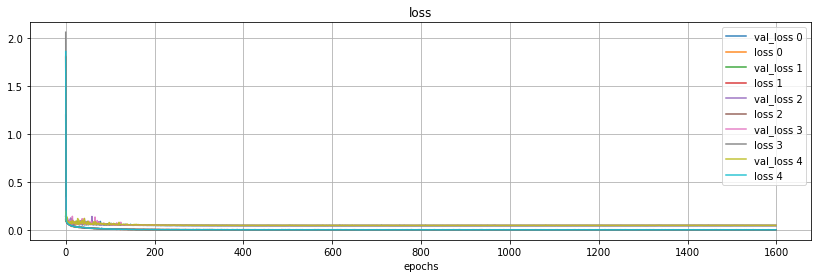

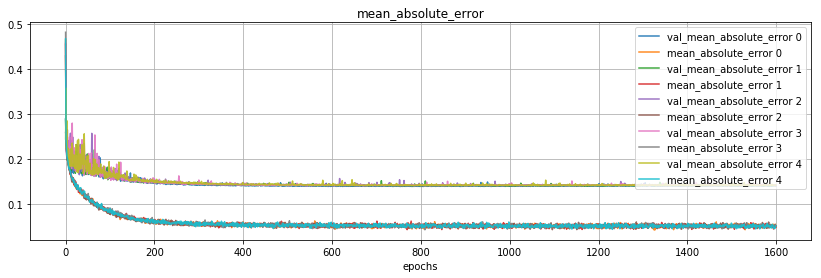

In [38]:
plot_keras_hist(hists)

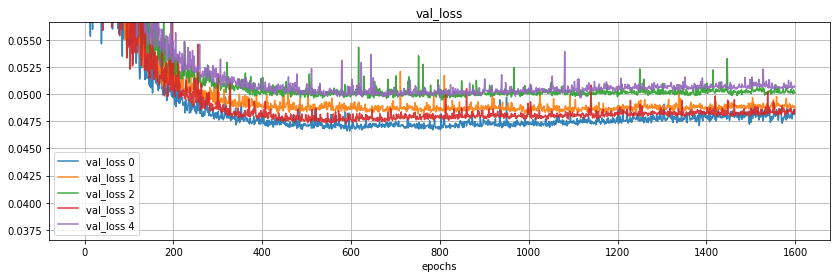

In [39]:
plot_keras_hist(hists, ylim=(min(hists[0].history['val_loss'])-0.01, 
                             min(hists[0].history['val_loss'])+0.01), metrics_plot=['val_loss'])

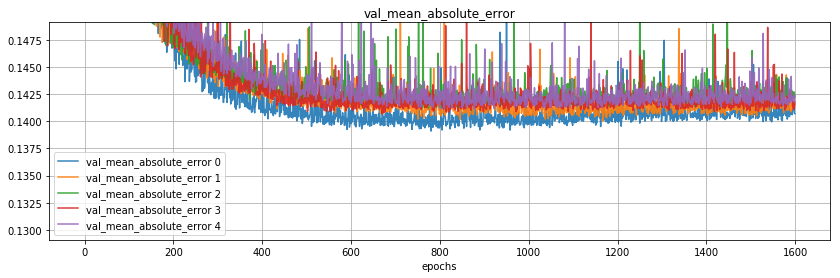

In [40]:
plot_keras_hist(hists, ylim=(min(hists[0].history['val_mean_absolute_error'])-0.01, 
                             min(hists[0].history['val_mean_absolute_error'])+0.01), metrics_plot=['val_mean_absolute_error'])

In [41]:
hist.params

{'batch_size': 256,
 'do_validation': True,
 'epochs': 1600,
 'metrics': ['loss',
  'mean_absolute_error',
  'val_loss',
  'val_mean_absolute_error'],
 'samples': 48000,
 'steps': None,
 'verbose': 2}

### One-fold prediction

In [42]:
sorted(best_iterations), np.mean(best_iterations), np.std(best_iterations)

([671, 775, 781, 878, 1168], 854.6, 169.84063118111638)

([456, 487, 675, 681, 692], 598.2, 104.05652310162972)

In [43]:
def ensemble_epochs(best_iterations):
    ep_step = max(int(round(np.std(best_iterations)/2)), 1)
    ep_mean = int(round(np.mean(best_iterations)))
    return np.arange(ep_mean-2*ep_step, ep_mean+2*ep_step+1, ep_step)

In [44]:
def concate_keras_hists(hist1, hist2):
    ''' Concate two keras history objects '''
    if hist1 is not None:
        for m in hist2.history:
            hist2.history[m] = hist1.history[m] + hist2.history[m]
        hist2.epoch = hist1.epoch + hist2.epoch
    return hist2

In [45]:
ensemble_epochs(best_iterations)

array([ 685,  770,  855,  940, 1025])

In [46]:
#params['epochs'] = int(np.mean(best_iterations))

In [47]:
params['ensemble_epochs'] = ensemble_epochs(best_iterations)

In [48]:
params

{'activation': 'prelu',
 'batch_norm': True,
 'batch_size': 256,
 'embedding_ratio': 4,
 'ensemble_epochs': array([ 685,  770,  855,  940, 1025]),
 'epochs': 1600,
 'learning_rate': 0.0009,
 'loss': 'mse',
 'n_neurons': (7400, 3700, 1850, 925)}

In [49]:
df_train = train.copy()
df_test = test.copy()

# Feature eng
feat_eng = FeatureEngineering(cols_num=cols_num, 
                              cols_cat=cols_cat, 
                              cols_bin=cols_bin, 
                              col_target=col_target, 
                              fillna_values=fillna_values, 
                              cols_right_skew=cols_right_skew,
                              is_embedding=is_embedding, 
                              is_tar_encoded=is_tar_encoded,
                              rare_village_threshold=rare_village_threshold, 
                              rare_town_threshold=rare_town_threshold,)
df_train = feat_eng.fit_transform(df_train, df_test)
df_test = feat_eng.transform(df_test)

# Construct X y matrices
if is_embedding:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
else:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
y_train = df_train[col_target+'_scaled']

# Compute network size
n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
if is_embedding:
    cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
else:
    cat_n_classes = {}
cat_embed_sizes = {c: min(int(params['embedding_ratio']*np.log(cat_n_classes[c]+1)+1), 
                          cat_n_classes[c]) for c in cat_n_classes}
print('Numerical input dims:', n_cols_num_bin)
print('Embeding  input dims:', cat_n_classes)
print('Embeding output dims:', cat_embed_sizes)
print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

# Build model
model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, **params)

# Train model
initial_epoch = 0
y_scaled_pred_ensemble = []
hist = None
for j, epochs in enumerate(params['ensemble_epochs']):
    hist_j = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=epochs, 
                       verbose=2, initial_epoch=initial_epoch,
                       callbacks=[GetBest(monitor='mean_absolute_error', verbose=0, mode='min')],
                      )
    print('[', j+1, '/', len(params['ensemble_epochs']),'] ensemble epochs:', epochs)
    hist = concate_keras_hists(hist, hist_j)
    
    model.save_weights(model_name+'-weights-'+'one-'+str(j)+'.h5')
    initial_epoch = epochs
    
    # Predict on test set    
    y_scaled_pred_ensemble.append(model.predict(X_test, batch_size=1024))

# Ensemble average of prediction
y_scaled_pred_ensemble = np.array(y_scaled_pred_ensemble)
print(y_scaled_pred_ensemble.shape)
df_test[col_target+'_scaled_pred'] = y_scaled_pred_ensemble.mean(axis=0)
feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')
df_test['total_price_pred'] = post_processing(df_test[col_target+'_pred'], df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': df_test['total_price_pred']})
display(df_test_pred.head(20))

Numerical input dims: 138
Embeding  input dims: {'town': 203, 'building_material': 10, 'encoded_latlon': 7, 'village': 2537, 'building_use': 11, 'parking_way': 4, 'building_type': 6, 'city': 12}
Embeding output dims: {'town': 22, 'building_material': 10, 'encoded_latlon': 7, 'building_type': 6, 'building_use': 10, 'parking_way': 4, 'village': 32, 'city': 11}
Total embedding output dims: 102
Epoch 1/685
 - 22s - loss: 1.4943 - mean_absolute_error: 0.4192
Epoch 2/685
 - 20s - loss: 0.0964 - mean_absolute_error: 0.2337
Epoch 3/685
 - 20s - loss: 0.0804 - mean_absolute_error: 0.2129
Epoch 4/685
 - 20s - loss: 0.0743 - mean_absolute_error: 0.2056
Epoch 5/685
 - 20s - loss: 0.0677 - mean_absolute_error: 0.1960
Epoch 6/685
 - 20s - loss: 0.0617 - mean_absolute_error: 0.1860
Epoch 7/685
 - 20s - loss: 0.0588 - mean_absolute_error: 0.1820
Epoch 8/685
 - 20s - loss: 0.0552 - mean_absolute_error: 0.1763
Epoch 9/685
 - 20s - loss: 0.0523 - mean_absolute_error: 0.1718
Epoch 10/685
 - 20s - loss: 0.

Epoch 121/685
 - 20s - loss: 0.0090 - mean_absolute_error: 0.0717
Epoch 122/685
 - 20s - loss: 0.0084 - mean_absolute_error: 0.0691
Epoch 123/685
 - 20s - loss: 0.0088 - mean_absolute_error: 0.0718
Epoch 124/685
 - 20s - loss: 0.0091 - mean_absolute_error: 0.0721
Epoch 125/685
 - 20s - loss: 0.0097 - mean_absolute_error: 0.0748
Epoch 126/685
 - 20s - loss: 0.0079 - mean_absolute_error: 0.0673
Epoch 127/685
 - 20s - loss: 0.0078 - mean_absolute_error: 0.0670
Epoch 128/685
 - 20s - loss: 0.0083 - mean_absolute_error: 0.0689
Epoch 129/685
 - 20s - loss: 0.0081 - mean_absolute_error: 0.0687
Epoch 130/685
 - 20s - loss: 0.0091 - mean_absolute_error: 0.0722
Epoch 131/685
 - 20s - loss: 0.0079 - mean_absolute_error: 0.0675
Epoch 132/685
 - 20s - loss: 0.0078 - mean_absolute_error: 0.0673
Epoch 133/685
 - 20s - loss: 0.0079 - mean_absolute_error: 0.0689
Epoch 134/685
 - 20s - loss: 0.0074 - mean_absolute_error: 0.0651
Epoch 135/685
 - 20s - loss: 0.0082 - mean_absolute_error: 0.0695
Epoch 136/

 - 20s - loss: 0.0047 - mean_absolute_error: 0.0538
Epoch 246/685
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0539
Epoch 247/685
 - 20s - loss: 0.0046 - mean_absolute_error: 0.0535
Epoch 248/685
 - 20s - loss: 0.0056 - mean_absolute_error: 0.0592
Epoch 249/685
 - 20s - loss: 0.0051 - mean_absolute_error: 0.0565
Epoch 250/685
 - 20s - loss: 0.0050 - mean_absolute_error: 0.0555
Epoch 251/685
 - 20s - loss: 0.0048 - mean_absolute_error: 0.0536
Epoch 252/685
 - 20s - loss: 0.0055 - mean_absolute_error: 0.0574
Epoch 253/685
 - 20s - loss: 0.0051 - mean_absolute_error: 0.0545
Epoch 254/685
 - 20s - loss: 0.0058 - mean_absolute_error: 0.0587
Epoch 255/685
 - 20s - loss: 0.0053 - mean_absolute_error: 0.0557
Epoch 256/685
 - 20s - loss: 0.0052 - mean_absolute_error: 0.0567
Epoch 257/685
 - 20s - loss: 0.0049 - mean_absolute_error: 0.0547
Epoch 258/685
 - 20s - loss: 0.0041 - mean_absolute_error: 0.0502
Epoch 259/685
 - 20s - loss: 0.0055 - mean_absolute_error: 0.0581
Epoch 260/685
 - 20s - l

Epoch 370/685
 - 20s - loss: 0.0052 - mean_absolute_error: 0.0561
Epoch 371/685
 - 20s - loss: 0.0041 - mean_absolute_error: 0.0488
Epoch 372/685
 - 20s - loss: 0.0045 - mean_absolute_error: 0.0508
Epoch 373/685
 - 20s - loss: 0.0056 - mean_absolute_error: 0.0590
Epoch 374/685
 - 20s - loss: 0.0044 - mean_absolute_error: 0.0526
Epoch 375/685
 - 20s - loss: 0.0051 - mean_absolute_error: 0.0554
Epoch 376/685
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0545
Epoch 377/685
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0525
Epoch 378/685
 - 20s - loss: 0.0052 - mean_absolute_error: 0.0573
Epoch 379/685
 - 20s - loss: 0.0048 - mean_absolute_error: 0.0525
Epoch 380/685
 - 20s - loss: 0.0044 - mean_absolute_error: 0.0523
Epoch 381/685
 - 20s - loss: 0.0048 - mean_absolute_error: 0.0535
Epoch 382/685
 - 20s - loss: 0.0042 - mean_absolute_error: 0.0504
Epoch 383/685
 - 20s - loss: 0.0052 - mean_absolute_error: 0.0572
Epoch 384/685
 - 20s - loss: 0.0048 - mean_absolute_error: 0.0536
Epoch 385/

 - 20s - loss: 0.0048 - mean_absolute_error: 0.0537
Epoch 495/685
 - 20s - loss: 0.0048 - mean_absolute_error: 0.0544
Epoch 496/685
 - 20s - loss: 0.0041 - mean_absolute_error: 0.0510
Epoch 497/685
 - 20s - loss: 0.0046 - mean_absolute_error: 0.0530
Epoch 498/685
 - 20s - loss: 0.0058 - mean_absolute_error: 0.0597
Epoch 499/685
 - 20s - loss: 0.0039 - mean_absolute_error: 0.0489
Epoch 500/685
 - 20s - loss: 0.0048 - mean_absolute_error: 0.0528
Epoch 501/685
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0530
Epoch 502/685
 - 20s - loss: 0.0045 - mean_absolute_error: 0.0525
Epoch 503/685
 - 20s - loss: 0.0052 - mean_absolute_error: 0.0568
Epoch 504/685
 - 20s - loss: 0.0046 - mean_absolute_error: 0.0523
Epoch 505/685
 - 20s - loss: 0.0049 - mean_absolute_error: 0.0540
Epoch 506/685
 - 20s - loss: 0.0043 - mean_absolute_error: 0.0519
Epoch 507/685
 - 20s - loss: 0.0044 - mean_absolute_error: 0.0507
Epoch 508/685
 - 20s - loss: 0.0042 - mean_absolute_error: 0.0506
Epoch 509/685
 - 20s - l

Epoch 619/685
 - 20s - loss: 0.0043 - mean_absolute_error: 0.0511
Epoch 620/685
 - 20s - loss: 0.0051 - mean_absolute_error: 0.0546
Epoch 621/685
 - 20s - loss: 0.0052 - mean_absolute_error: 0.0566
Epoch 622/685
 - 20s - loss: 0.0049 - mean_absolute_error: 0.0555
Epoch 623/685
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0533
Epoch 624/685
 - 20s - loss: 0.0042 - mean_absolute_error: 0.0502
Epoch 625/685
 - 20s - loss: 0.0045 - mean_absolute_error: 0.0514
Epoch 626/685
 - 20s - loss: 0.0044 - mean_absolute_error: 0.0528
Epoch 627/685
 - 20s - loss: 0.0053 - mean_absolute_error: 0.0580
Epoch 628/685
 - 20s - loss: 0.0049 - mean_absolute_error: 0.0546
Epoch 629/685
 - 20s - loss: 0.0043 - mean_absolute_error: 0.0504
Epoch 630/685
 - 20s - loss: 0.0043 - mean_absolute_error: 0.0499
Epoch 631/685
 - 20s - loss: 0.0052 - mean_absolute_error: 0.0570
Epoch 632/685
 - 20s - loss: 0.0043 - mean_absolute_error: 0.0507
Epoch 633/685
 - 20s - loss: 0.0041 - mean_absolute_error: 0.0509
Epoch 634/

Epoch 743/770
 - 20s - loss: 0.0043 - mean_absolute_error: 0.0518
Epoch 744/770
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0530
Epoch 745/770
 - 20s - loss: 0.0040 - mean_absolute_error: 0.0476
Epoch 746/770
 - 20s - loss: 0.0050 - mean_absolute_error: 0.0557
Epoch 747/770
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0536
Epoch 748/770
 - 20s - loss: 0.0048 - mean_absolute_error: 0.0541
Epoch 749/770
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0540
Epoch 750/770
 - 20s - loss: 0.0050 - mean_absolute_error: 0.0559
Epoch 751/770
 - 20s - loss: 0.0050 - mean_absolute_error: 0.0556
Epoch 752/770
 - 20s - loss: 0.0045 - mean_absolute_error: 0.0528
Epoch 753/770
 - 20s - loss: 0.0046 - mean_absolute_error: 0.0536
Epoch 754/770
 - 20s - loss: 0.0053 - mean_absolute_error: 0.0567
Epoch 755/770
 - 20s - loss: 0.0052 - mean_absolute_error: 0.0559
Epoch 756/770
 - 20s - loss: 0.0046 - mean_absolute_error: 0.0529
Epoch 757/770
 - 20s - loss: 0.0049 - mean_absolute_error: 0.0547
Epoch 758/

 - 20s - loss: 0.0039 - mean_absolute_error: 0.0489
Epoch 867/940
 - 20s - loss: 0.0045 - mean_absolute_error: 0.0527
Epoch 868/940
 - 20s - loss: 0.0053 - mean_absolute_error: 0.0565
Epoch 869/940
 - 20s - loss: 0.0042 - mean_absolute_error: 0.0495
Epoch 870/940
 - 20s - loss: 0.0046 - mean_absolute_error: 0.0534
Epoch 871/940
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0524
Epoch 872/940
 - 20s - loss: 0.0046 - mean_absolute_error: 0.0530
Epoch 873/940
 - 20s - loss: 0.0043 - mean_absolute_error: 0.0537
Epoch 874/940
 - 20s - loss: 0.0049 - mean_absolute_error: 0.0538
Epoch 875/940
 - 20s - loss: 0.0038 - mean_absolute_error: 0.0467
Epoch 876/940
 - 20s - loss: 0.0044 - mean_absolute_error: 0.0515
Epoch 877/940
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0539
Epoch 878/940
 - 20s - loss: 0.0037 - mean_absolute_error: 0.0476
Epoch 879/940
 - 20s - loss: 0.0043 - mean_absolute_error: 0.0504
Epoch 880/940
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0542
Epoch 881/940
 - 20s - l

 - 20s - loss: 0.0046 - mean_absolute_error: 0.0528
Epoch 990/1025
 - 20s - loss: 0.0045 - mean_absolute_error: 0.0522
Epoch 991/1025
 - 20s - loss: 0.0049 - mean_absolute_error: 0.0569
Epoch 992/1025
 - 20s - loss: 0.0046 - mean_absolute_error: 0.0531
Epoch 993/1025
 - 20s - loss: 0.0043 - mean_absolute_error: 0.0515
Epoch 994/1025
 - 20s - loss: 0.0042 - mean_absolute_error: 0.0517
Epoch 995/1025
 - 20s - loss: 0.0046 - mean_absolute_error: 0.0530
Epoch 996/1025
 - 20s - loss: 0.0046 - mean_absolute_error: 0.0539
Epoch 997/1025
 - 20s - loss: 0.0053 - mean_absolute_error: 0.0579
Epoch 998/1025
 - 20s - loss: 0.0047 - mean_absolute_error: 0.0538
Epoch 999/1025
 - 20s - loss: 0.0041 - mean_absolute_error: 0.0497
Epoch 1000/1025
 - 20s - loss: 0.0041 - mean_absolute_error: 0.0486
Epoch 1001/1025
 - 20s - loss: 0.0040 - mean_absolute_error: 0.0495
Epoch 1002/1025
 - 20s - loss: 0.0043 - mean_absolute_error: 0.0507
Epoch 1003/1025
 - 20s - loss: 0.0053 - mean_absolute_error: 0.0555
Epoch 

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.353101e+07
1,BTshNOJyKHnT2YIT,3.910961e+06
2,dhdymr0lV8N5kZOT,1.214934e+07
3,VEwyGGMcD56w5BOc,5.810752e+06
4,wmUeMoJZfsqaSX9b,1.008120e+06
5,EtBjGAHmHCe9t7TZ,2.223359e+06
6,hPNH34vmaZtvBtqc,1.213499e+07
7,wXjeI38bYDMJJwZC,5.803456e+06
8,fxZSGX6aPAFKU8W4,1.713083e+06
9,ewr0Fx6ign87OwaV,4.062416e+06


In [50]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

In [54]:
model.evaluate(x=X_train, y=y_train, batch_size=1024)

60000/60000 [==============================] - 4s 64us/step


[0.0007264764949368934, 0.014288856681187947]

#### Hist

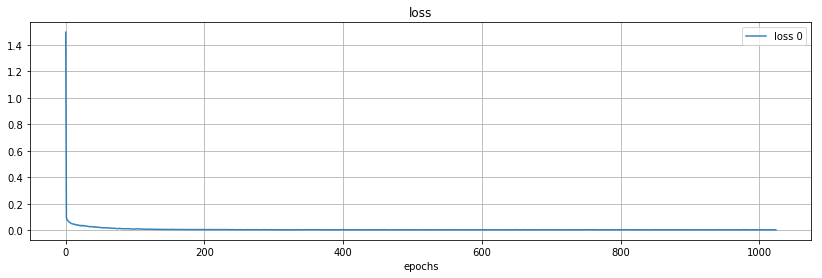

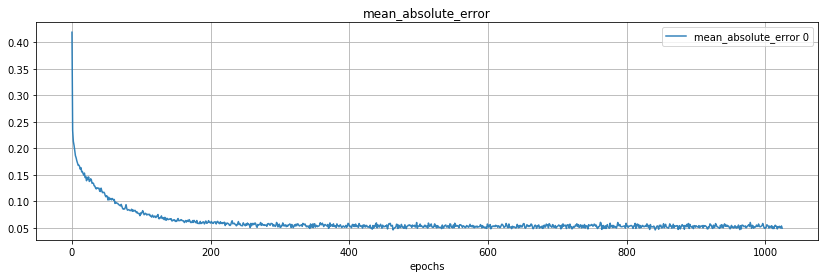

In [51]:
plot_keras_hist(hist)

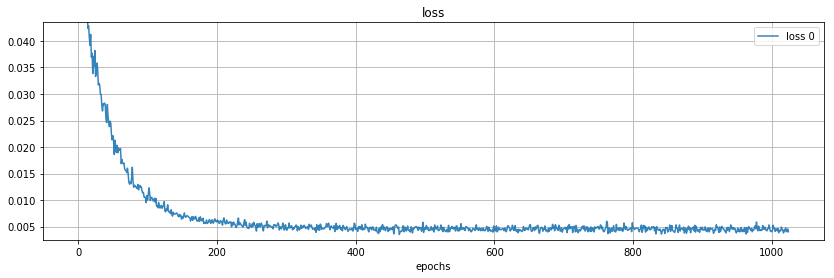

In [52]:
plot_keras_hist(hist, ylim=(min(hist.history['loss'])-0.001, 
                            min(hist.history['loss'])+0.04), metrics_plot=['loss'])

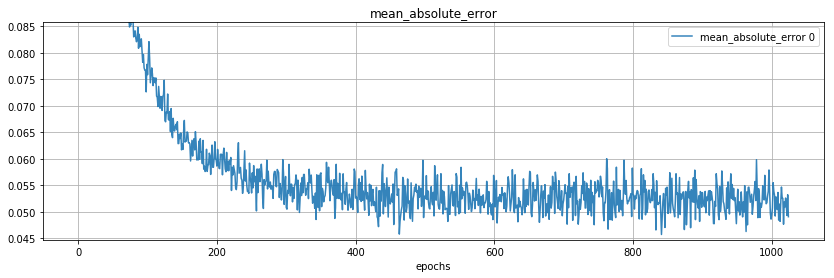

In [53]:
plot_keras_hist(hist, ylim=(min(hist.history['mean_absolute_error'])-0.001, 
                            min(hist.history['mean_absolute_error'])+0.04), metrics_plot=['mean_absolute_error'])

### Result

Leaderboard:
- kfold:
- one ensemble: